# Taxonomic summaries

Author: Monica R. Ticlla Ccenhua <br>
e-mail: mticlla@gmail.com monicaroxana.ticllaccenhua@unibas.ch

**Summary**

Taxonomic summaries were obtained by aggregating the relative abundances by taxonomic rank, from Genus to Domains, and computing the means across samples. To visualize species-level and genus-level community composition profiles across samples, we created heatmaps with sputum samples and taxa sorted according to agglomerative hierarchical clustering based on Aitchison distances.

In [1]:
report_date = %env REPORT_DATE
print(report_date)

2020-07-16


## 0. Set-up working environment

**Set-up working directory**

In [2]:
%%capture
cd ../

**Import python modules**

In [3]:
%load_ext rpy2.ipython

.Rprofile: Setting Swiss repository



**Import R packages**

In [4]:
%%capture
%%R
library(phyloseq)
library(simpleboot)
library(boot)
library(ggplot2)
library(hrbrthemes)
hrbrthemes::import_roboto_condensed()
library(RColorBrewer)
library(grid)
library(gridExtra)
library(zCompositions)
library(scales)
library(pheatmap)
library(dendsort)
library(vegan)
library(usedist)

options("width"=200)


Lets define some local functions:

In [5]:
%%R
## Summarizes data.
## Gives count, mean, standard deviation, standard error(se) of the mean, and confidence interval (default 95%).
## Standard error and confidence intervals are computed by stundendized boostrap method
##   data: a data frame.
##   measurevar: the name of a column that contains the variable to be summarized
##   groupvars: a vector containing names of columns that contain grouping variables
##   na.rm: a boolean that indicates whether to ignore NA's
##   conf.interval: the percent range of the confidence interval (default is 95%)
##   R: number of bootstraps to compute conf.interval
summarySE.bootstrap <- function(data=NULL, measurevar, groupvars=NULL, na.rm=FALSE,
                      conf.interval=.95, .drop=TRUE, .R=100) {
    library(plyr)
    library(simpleboot)
    library(boot)

    # New version of length which can handle NA's: if na.rm==T, don't count them
    length2 <- function (x, na.rm=FALSE) {
        if (na.rm) sum(!is.na(x))
        else       length(x)
    }

    # This does the summary. For each group's data frame, return a vector with
    # N, mean, sd, se, lci and uci
    datac <- plyr::ddply(data, groupvars, .drop=.drop,
                         .fun = function(xx, col) {
                             N = length2(xx[[col]], na.rm=na.rm)
                             if (N >=5) {
                                 #Studentized, bootstraped CIs
                                 bmean = one.boot(xx[[col]], mean, student=TRUE, M=round(.R/10), R=.R, 
                                                  na.rm=na.rm)
                                 bmean.ci = boot.ci(bmean,type = "stud")
                                 c(N    = length2(xx[[col]], na.rm=na.rm),
                                   mean = mean   (xx[[col]], na.rm=na.rm),
                                   sd   = sd     (xx[[col]], na.rm=na.rm),
                                   se   = sd(bmean$t[,1]),
                                   lci  = bmean.ci$student[4],
                                   uci  = bmean.ci$student[5]
                              )
                             } else {
                                 c(N    = length2(xx[[col]], na.rm=na.rm),
                                   mean = mean   (xx[[col]], na.rm=na.rm),
                                   sd   = sd     (xx[[col]], na.rm=na.rm),
                                   se   = NA,
                                   lci  = NA,
                                   uci  = NA
                              )
                                 
                             }

                         },
                         measurevar
                        )

    # Rename the "mean" column    
    datac <- plyr::rename(datac, c("mean" = measurevar))
    return(datac)
}

merge_samples_mean <- function(phyloseq.obj,group.name){
    group <- get_variable(phyloseq.obj, group.name)
    group_levels <- levels(group)
    group_totals <- table(group)
    # merge the values that correspond to the same group for each variable (OTU)
    # returns the sum
    otuTable.merged <- merge_samples(phyloseq.obj,group)
    names.otuTable.merged <- rownames(otu_table(otuTable.merged))
    # convert sums to means
    otu_table(otuTable.merged) <- otu_table(otuTable.merged)/as.vector(group_totals[names.otuTable.merged])
    return(otuTable.merged)
}

get_mean_abundances_by_rank <- function(phyloseq.obj, group.name, rank.name, condensed=FALSE){
    merged_means <- merge_samples_mean(phyloseq.obj,group.name)
    merged_means_by_rank <- tax_glom(merged_means,rank.name,NArm=FALSE)
    means_by_rank <- t(otu_table(merged_means_by_rank))
    means_by_rank <- means_by_rank[order(means_by_rank[,1], decreasing=TRUE),]
    otu_table(merged_means_by_rank) <- t(means_by_rank)
    if(condensed){
        return(data.frame(tax_table(merged_means_by_rank)[,rank.name],
                          t(otu_table(merged_means_by_rank))
                         )
              )
    }else{
        return(merged_means_by_rank)
    }
}

# Summarize relative abundances by taxonomic rank and sample categories
# variables: variables from the Sample Data table in the phyloseq object, used to split it by.
# 
summarize_relative_abundances <- function(phyloseq.obj, rank="Phylum", variables=NULL, top=NULL, rank.names=NULL,
                                     format=c('ra','counts'), rank.NArm=FALSE){
    if(format == 'ra'){
        physeq_ra <- phyloseq.obj
    }else{
        # Tansform count to relative abundances in %
        physeq_ra <- transform_sample_counts(phyloseq.obj, function(x) 100*x/sum(x))
    }
                                             
    if(rank == 'OTU'){
        physeq_ra_rank <- phyloseq.obj
    }else{
        physeq_ra_rank <- tax_glom(physeq_ra, rank, NArm=rank.NArm) 
    }                                        
    
    if(!is.null(top)){
        top_rank_ix <- names(sort(taxa_sums(physeq_ra_rank)/nsamples(physeq_ra_rank), 
                                  decreasing = TRUE)[1:top])
        physeq_ra_rank <- prune_taxa(top_rank_ix,physeq_ra_rank)
        top_rank_names <-  as.character(tax_table(physeq_ra_rank)[top_rank_ix,rank])
    }
    physeq_ra_rank_df <- psmelt(physeq_ra_rank)
    
    if(!is.null(variables)){
        #if(length(variables)>=1){
        #    variables = c(variables, rank)
        #}else {
        #    variables = rank
        #}
        variables = c(variables, rank)
    }else{
        variables = rank
    }
                                             
    physeq_ra_rank_df_summary <- plyr::ddply(physeq_ra_rank_df, .variables=variables, 
                                       summarySE.bootstrap, measurevar='Abundance')

    return(physeq_ra_rank_df_summary[, !names(physeq_ra_rank_df_summary) %in% c('.id')])
}


plot_relative_abundance_summary <- function(summary_table, rank="Phylum", by_var=NULL,threshold=0.01, top=NULL, 
                                            coverage=99, scale=c(NULL,"fraction","percent"), 
                                            names_format=c(NULL,"gg")){
    library(ggplot2)
    library(hrbrthemes)
    hrbrthemes::import_roboto_condensed()
    library(RColorBrewer)
    
    summary_table_toplot <- summary_table
    
    if(is.null(by_var)){
        by_var='dataset'
        summary_table_toplot$dataset <- "Dataset"
    }
    if(is.null(scale)){
        y_min <- min(summary_table_toplot$Abundance)
        y_max <- max(summary_table_toplot$Abundance)
        y_limits <- c(y_min,y_max)
        y_breaks <- seq(y_min, y_max, length.out=6)
    }else if (scale=='fraction'){
        y_limits <- c(0,1)
        y_breaks <- seq(0,1, by=0.2)
    }else if (scale=='percent'){
        y_limits <- c(0,100)
        y_breaks <- seq(0,100, by=20)        
    }else{
        cat("Non-valid value for scale. Valid values are 'fraction', 'percent' or NULL")
    }
    
    # Define levels of rank
    # ---------------------
    # Agregate abundances (by each level of rank, abundances of all levels of by_var are averaged)
    # function aggregate returns a dataframe with two columns (rank, x)
    # x corresponds to the averaged abundances
    rank_aggregated_means <- aggregate(summary_table_toplot[,'Abundance'], 
                                           by=list(rank=summary_table_toplot[,rank]), mean)
    # Sort rank levels by their decreasing abundance(x)
    rank_names_sorted <- as.character(rank_aggregated_means$rank[order(rank_aggregated_means$x, 
                                                                       decreasing=TRUE)])
    #rank_isna_ix <- which(is.na(summary_table_toplot[,rank]))
    #rank_names <- summary_table_toplot[-rank_isna_ix,rank]
    #rank_names_sorted <- as.character(rank_names[order(summary_table_toplot[-rank_isna_ix,'Abundance'],
    #                                                   decreasing=TRUE)])
    if(is.null(names_format)){
        summary_table_toplot[,rank] <- factor(summary_table_toplot[,rank],
                                              levels=c(NA, rank_names_sorted),
                                              labels=c("NA", rank_names_sorted), 
                                              exclude=NULL)
    }else if(names_format=='gg'){
        rank_names_labels <- unlist(lapply(as.character(rank_names_sorted), 
                                     function(x){strsplit(x,'__')[[1]][2]}))
        # Relevel Rank (rename NA as "Unclassified" and place it on top)
        summary_table_toplot[,rank] <- factor(summary_table_toplot[,rank], 
                                              levels=c(NA, rank_names_sorted), 
                                              labels=c("Unclassified", rank_names_labels), 
                                              exclude=NULL)
    }
    
    # Define wich levels of rank to plot
    # ----------------------------------
    # Color only rank above abundance threshold, plus unclassified
    # rank levels above threshold (NA not considered)
    rank_abv01 <- rank_aggregated_means$x > threshold
    #rank_abv01 <- summary_table_toplot$Abundance[-rank_isna_ix]>threshold
    nb_colors <- sum(rank_abv01)
    rank_colors <- c("black", # color for NA or Unclassified reads
                     colorRampPalette(brewer.pal(12, "Paired"))(nb_colors), # colors for rank levels above threshold
                     rep("white", length(rank_abv01)-(nb_colors))) # the rest is colored white
    my_plot <- ggplot(summary_table_toplot, aes(x=get(by_var),y=Abundance)) + 
               geom_col(aes(fill=get(rank)), position=position_stack(reverse=TRUE), width=0.95) + 
               scale_fill_manual(name=rank, values=rank_colors, 
                                 limits=levels(summary_table_toplot[,rank])[1:(nb_colors+1)]) + 
               scale_y_continuous(limits=y_limits, breaks=y_breaks) +
               labs(x=by_var)+
               theme_ipsum()
    return(my_plot)
}

## 1. Input files

### 1.1 16S-AS taxonomic profiles

In [6]:
%%R
# Loading the feature table
# -------------------------
asv16s_qiime2_feature_table_file <- "./data/interim/QIIME2/tz_spt_cases_fwd/artifacts/decontam/decontam_table.tsv"
asv16s_qiime2_feature_table <- read.table(asv16s_qiime2_feature_table_file, header=TRUE, sep='\t', 
                                          stringsAsFactors=FALSE, quote = "", check.names=FALSE, row.names=1, 
                                          comment.char="", skip=1)
asv16s_qiime2_feature_table[0:3,0:3]

# Loading the taxonomy table
# --------------------------
#' Convert taxonomy table produced by QIIME2 to a 7-ranks data frame
#'
#' @param qiime2_taxonomy A data frame with columns c('Taxon', 'Confidence')
#' @return The taxonomy table as dataframe with seven columns, the seven taxonomic ranks.
qiime2taxonomy_to_df <- function(qiime2_taxonomy){
    features_ids <- rownames(qiime2_taxonomy)
    taxon_ranks_n = 7
    taxon_rank_names = c("Kingdom","Phylum","Class","Order","Family","Genus","Species")
    taxonomies = sapply(qiime2_taxonomy$Taxon, 
                        function(x,nranks){
                            taxonomy_vector = strsplit(x,'; ')[[1]]
                            na_vector = rep(NA,nranks-length(taxonomy_vector))
                            c(taxonomy_vector,na_vector)}, 
                        taxon_ranks_n)
    taxonomies = data.frame(matrix(taxonomies, 
                                   nrow=length(features_ids), 
                                   ncol=taxon_ranks_n, byrow=TRUE), 
                            row.names=features_ids, 
                            stringsAsFactors=FALSE)
    colnames(taxonomies) <- taxon_rank_names
    return(taxonomies)
}

# Load taxonomies
asv16s_taxonomy_table_file <- './data/interim/QIIME2/tz_spt_cases_fwd/artifacts/taxonomy/exported/taxonomy.tsv'
asv16s_taxonomy_table <- read.table(asv16s_taxonomy_table_file, header=TRUE, sep='\t', stringsAsFactors=FALSE, 
                                    quote="", check.names=FALSE, row.names=1)
asv16s_taxonomy_table <- qiime2taxonomy_to_df(asv16s_taxonomy_table)
print(dim(asv16s_taxonomy_table))
print(asv16s_taxonomy_table[0:3,0:3])

cat("\nNr of ASVs: ")
cat(dim(asv16s_taxonomy_table)[1])

cat("\nNr of taxonomic levels: ")
cat(dim(asv16s_taxonomy_table)[2])

# Create phyloseq object
# ----------------------
# Re-format taxonomy table for phyloseq
# Replace non-assigned taxonomy ranks(e.g p__) with NA
is_undefined_rank <- t(unlist(apply(asv16s_taxonomy_table, 1, 
                                    function(x){x %in% c("k__","p__","c__","o__","f__","g__","s__")})))
asv16s_taxonomy_table_ps <- asv16s_taxonomy_table
asv16s_taxonomy_table_ps[ is_undefined_rank ] <- NA

# Lets create the phyloseq object (feature/otu table and taxonomy tables merged)
asv16s_feature_table_ps <- phyloseq(otu_table(asv16s_qiime2_feature_table, 
                                              taxa_are_rows=TRUE), 
                                    tax_table(as.matrix(asv16s_taxonomy_table_ps)))
print(asv16s_feature_table_ps)


# Remove samples with less than 12000 total reads
asv16s_feature_table_ps <- prune_samples(sample_sums(asv16s_feature_table_ps) >=12000, 
                                         asv16s_feature_table_ps)

# remove ASV with abundance zero
asv16s_feature_table_ps = filter_taxa(asv16s_feature_table_ps, function(x){sum(x) > 0}, TRUE)

cat("\nContent of Phyloseq object: \n")
print(asv16s_feature_table_ps)

[1] 28284     7
                                     Kingdom           Phylum          Class
0000134bb4f9a56941dd1d0206a600d8 k__Bacteria p__Bacteroidetes c__Bacteroidia
00032a9354651fef5c866ec3f9cdca0d k__Bacteria p__Bacteroidetes c__Bacteroidia
000374910b98b14cc5724af75f294b87 k__Bacteria p__Bacteroidetes c__Bacteroidia

Nr of ASVs: 28284
Nr of taxonomic levels: 7phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 28274 taxa and 335 samples ]
tax_table()   Taxonomy Table:    [ 28274 taxa by 7 taxonomic ranks ]

Content of Phyloseq object: 
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 27668 taxa and 307 samples ]
tax_table()   Taxonomy Table:    [ 27668 taxa by 7 taxonomic ranks ]


Lets check the species-level resolution:

In [7]:
%%R
asv_unassigned_sp_n <- sum(is.na(tax_table(asv16s_feature_table_ps)[,"Species"]))
cat("Number of ASVs with unassigned species classification:\n")
print(asv_unassigned_sp_n)
cat("Proportion of ASVs with unassigned species-level taxonomy:\n")
print(asv_unassigned_sp_n/ntaxa(asv16s_feature_table_ps))

Number of ASVs with unassigned species classification:
[1] 23733
Proportion of ASVs with unassigned species-level taxonomy:
[1] 0.8577779


Lets check the genus-level resolution:

In [8]:
%%R
asv_unassigned_genus_n <- sum(is.na(tax_table(asv16s_feature_table_ps)[,"Genus"]))
cat("Number of ASVs with unassigned genus classification:\n")
print(asv_unassigned_genus_n)
cat("Proportion of ASVs with unassigned genus classification:\n")
print(asv_unassigned_genus_n/ntaxa(asv16s_feature_table_ps))
cat("Number of distinct genera detected:\n")
print(length(unique(na.omit(tax_table(asv16s_feature_table_ps)[,"Genus"]))))

Number of ASVs with unassigned genus classification:
[1] 12497
Proportion of ASVs with unassigned genus classification:
[1] 0.451677
Number of distinct genera detected:
[1] 320


### 1.2 WMS-S taxonomic profiles

In [9]:
%%R
# Load taxonomic abundance profiles (relative abundances)
wms_abundance_table_file <- "./data/interim/MetaSnk/wms_cases/PhlAnProf/metaphlan/profiles_merged/wms_cases_abundances_table.txt"
wms_abundance_table <- read.table(wms_abundance_table_file, header=TRUE, sep='\t', 
                                  stringsAsFactors=FALSE, quote = "", check.names=FALSE, row.names=1)
print(wms_abundance_table[1:5,1:2])
cat("\nDimensions of data before filtering\n")
cat("\nNr of samples: ")
cat(dim(wms_abundance_table)[2])
cat("\nNr of taxa: ")
cat(dim(wms_abundance_table)[1])

# Remove samples with high levels of contaminant spp.
# List of contaminated samples
wms_samples_highcont_file <- "./data/interim/wms_contaminated_samples_ids.tsv"
wms_samples_highcont <- readLines(file(wms_samples_highcont_file))
cat("\n\nNumber of samples highly contaminated: ")
cat(length(wms_samples_highcont))
cat("\nSamples highly contaminated: \n")
print(wms_samples_highcont)
metaphlan_all_spp_contaminated_samples_ix <- which(colnames(wms_abundance_table) %in% wms_samples_highcont)
wms_abundance_table <- wms_abundance_table[,-metaphlan_all_spp_contaminated_samples_ix]
print(dim(wms_abundance_table))

# Remove samples with high percentage of unclassified reads
# Distribution of percentage of "unclassified" reads per sample
cat("\n\nDistribution of percentage of 'unclassified' reads per sample")
print(table(t(wms_abundance_table["unclassified",])))
has_only_unclassified <- as.vector(t(wms_abundance_table["unclassified",])==100)
mp_unclassified_samples <- colnames(wms_abundance_table)[has_only_unclassified]
cat("Samples with only unclassified reads: \n")
cat(colnames(wms_abundance_table)[has_only_unclassified])
wms_abundance_table <- wms_abundance_table[,!has_only_unclassified]

# Remove samples with abnormal percentage of human DNA
wms_stats_file <- "./data/interim/MetaSnk/wms_cases/preQC/summary_stats/wms_cases_preqc_samples_summary.tsv"
wms_stats <- read.table(wms_stats_file, sep="\t", header=TRUE, row.names=1)
cat("\n\nPercent Human: \n")
print(summary(wms_stats$filter_human_pct_disc))
samples_wit_lowpct_human <- rownames(wms_stats)[wms_stats$filter_human_pct_disc<50]
cat("\nSamples with low percentage of human reads (<50%): ",length(samples_wit_lowpct_human), "\n")
cat(samples_wit_lowpct_human)
is_lowpct_human <- colnames(wms_abundance_table) %in% samples_wit_lowpct_human
cat("\nSamples with low percentage of human reads (<50%) not yet removed by previous filters: ",
    sum(is_lowpct_human), "\n")
wms_abundance_table <- wms_abundance_table[,!is_lowpct_human]

# Remove taxa with zero total counts
taxa_has_only_zeros <- rowSums(wms_abundance_table)==0
wms_abundance_table <- wms_abundance_table[!taxa_has_only_zeros,]
cat("\n\nNr of taxa with zero totals: \n")
cat(sum(taxa_has_only_zeros))

cat("\n\nDimensions of data after filtering\n")
cat("\nNr of samples: ")
cat(dim(wms_abundance_table)[2])
cat("\nNr of taxa: ")
cat(dim(wms_abundance_table)[1])

                                                                                          M00186   M00158
k__Bacteria                                                                            100.00000 89.48721
k__Bacteria|p__Actinobacteria                                                           91.74722 36.23369
k__Bacteria|p__Actinobacteria|c__Actinobacteria                                         91.74722 36.23369
k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales                      91.74722 36.23369
k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae   0.00000  0.00000

Dimensions of data before filtering

Nr of samples: 129
Nr of taxa: 1094

Number of samples highly contaminated: 22
Samples highly contaminated: 
 [1] "M00176" "M00161" "M00226" "M00269" "M00081" "M00111" "M00065" "M00084" "M00094" "M00054" "M00219" "M00276" "M00086" "M00135" "M00004" "M00090" "M00229" "M00122" "M00033" "M00001" "M00241"
[22] "M00218"
[1] 1094 

**Split taxon abundances by taxonomic ranks**

In [10]:
%%R
# Taxon IDs per rank
kingdoms <- grep("\\|",rownames(wms_abundance_table), value=TRUE, invert=TRUE)
species_all <- grep("^k__[[:graph:]]*\\|s__[^\\|]*$", rownames(wms_abundance_table), value=TRUE)
cat("\nNr of species: ", length(species_all))

bacteria_phyla <- grep("^k__Bacteria\\|p__[^\\|]*$", 
                       rownames(wms_abundance_table), value=TRUE)
bacteria_class <- grep("^k__Bacteria\\|p__[^\\|]*\\|c__[^\\|]*$",
                       rownames(wms_abundance_table), value=TRUE)
bacteria_order <- grep("^k__Bacteria[[:graph:]]*\\|o__[^\\|]*$", 
                       rownames(wms_abundance_table), value=TRUE)
bacteria_family <- grep("^k__Bacteria[[:graph:]]*\\|f__[^\\|]*$",
                          rownames(wms_abundance_table), value=TRUE)
bacteria_genus <- grep("^k__Bacteria[[:graph:]]*\\|g__[^\\|]*$", 
                       rownames(wms_abundance_table), value=TRUE)
bacteria_species <- grep("^k__Bacteria[[:graph:]]*\\|s__[^\\|]*$", 
                         rownames(wms_abundance_table), value=TRUE)
bacteria_strains <- grep("^k__Bacteria[[:graph:]]*\\|t__[^\\|]*$", 
                         rownames(wms_abundance_table), value=TRUE)

# Remoce Species/strains flagged as contaminants by decontam
# List of potential contamiant spp.
wms_contaminants_ids_file <- "./data/interim/wms_contaminants_decontam.tsv"
wms_contaminants_ids <- read.table(wms_contaminants_ids_file, sep='\t',header=TRUE, stringsAsFactors=FALSE)

species_all <- names(which(sapply(species_all, 
                                   function(x){
                                       if(sum(stringr::str_detect(x,wms_contaminants_ids$sp_id))>0){
                                           FALSE
                                       }else{
                                           TRUE
                                       }
                                   })))
cat("\nNr of species after removing potential contaminants: ", length(species_all))

bacteria_species <- names(which(sapply(bacteria_species,
                                       function(x){
                                           if(sum(stringr::str_detect(x,wms_contaminants_ids$sp_id))>0){
                                               FALSE
                                           }else{
                                               TRUE
                                           }
                                       })))

bacteria_strains <- names(which(sapply(bacteria_strains, 
                                       function(x){
                                           if(sum(stringr::str_detect(x,wms_contaminants_ids$sp_id))>0){
                                               FALSE
                                           }else{
                                               TRUE
                                           }
                                       })))

# Kingdom / Domain abundance
# -------------------------
# Relative abundances
wms_kigdom_abund_table <- wms_abundance_table[kingdoms,]
wms_kigdom_abund_table <- wms_kigdom_abund_table[rowSums(wms_kigdom_abund_table) > 0,]
# Obtain relative counts 
wms_kigdom_counts_table <- t(apply(wms_kigdom_abund_table,1,
                                   function(x,x_totals){round((x*x_totals)/100)}, 
                                   x_totals=wms_stats[colnames(wms_kigdom_abund_table),"total_kept_reads"]))

# Species abundances
# ---------------------
# Relative abundances (%)
wms_all_spp_abund_table <- wms_abundance_table[species_all,]
wms_all_spp_abund_table <- wms_all_spp_abund_table[rowSums(wms_all_spp_abund_table)>0,]
# Relative counts
wms_all_spp_counts_table <- t(apply(wms_all_spp_abund_table,1,
                                   function(x,x_totals){round((x*x_totals)/100)}, 
                                   x_totals=wms_stats[colnames(wms_all_spp_abund_table),"total_kept_reads"]))

# Taxonomy assignment
wms_all_spp_taxonomy <- as.data.frame(do.call(rbind,strsplit(rownames(wms_all_spp_counts_table),"\\|")))
colnames(wms_all_spp_taxonomy) <- c("Kingdom","Phylum","Class","Order","Family","Genus","Species")
rownames(wms_all_spp_taxonomy) <- wms_all_spp_taxonomy$Species

rownames(wms_all_spp_counts_table) <- wms_all_spp_taxonomy$Species
rownames(wms_all_spp_abund_table) <- wms_all_spp_taxonomy$Species


# Taxon abundances per Bacterial rank 
# -----------------------------------
#wms_bacteria_totals = t(wms_kigdom_counts_table["k__Bacteria",])
##---Bacterial Phyla
# Relative abundances
wms_bacteria_phyla_abund_table <- wms_abundance_table[bacteria_phyla,]
wms_bacteria_phyla_abund_table <- wms_bacteria_phyla_abund_table[rowSums(wms_bacteria_phyla_abund_table) > 0,]
# Obtain relative counts 
wms_bacteria_phyla_counts_table <- t(apply(wms_bacteria_phyla_abund_table,1,
                                   function(x,x_totals){round((x*x_totals)/100)}, 
                                   x_totals=wms_stats[colnames(wms_bacteria_phyla_abund_table),"total_kept_reads"]))
# re-scale, make abundances(%) relative to Bacterial total abundance
wms_bacteria_phyla_abund_table <- apply(wms_bacteria_phyla_abund_table,2,function(x){total=sum(x)
                                                                                     (x/total)*100
                                                                                    })
# Estimated counts
#wms_bacteria_phyla_counts_table <- wms_counts_table[rownames(wms_bacteria_phyla_abund_table),]
# Renaming
wms_phyla_names <- unlist(lapply(rownames(wms_bacteria_phyla_abund_table), 
                                 function(x){strsplit(x, split="\\|")[[1]][2]}))
rownames(wms_bacteria_phyla_abund_table) <- wms_phyla_names
rownames(wms_bacteria_phyla_counts_table) <- wms_phyla_names

cat("\nNr of bacterial phyla:")
cat(dim(wms_bacteria_phyla_abund_table)[1])

##---Bacterial Class
wms_bacteria_class_abund_table <- wms_abundance_table[bacteria_class,]
wms_bacteria_class_abund_table <- wms_bacteria_class_abund_table[rowSums(wms_bacteria_class_abund_table) > 0,]
# Obtain relative counts
wms_bacteria_class_counts_table <- t(apply(wms_bacteria_class_abund_table,1,
                                   function(x,x_totals){round((x*x_totals)/100)}, 
                                   x_totals=wms_stats[colnames(wms_bacteria_class_abund_table),"total_kept_reads"]))
# re-scale, make abundances(%) relative to Bacterial total abundance
wms_bacteria_class_abund_table <- apply(wms_bacteria_class_abund_table,2,function(x){total=sum(x)
                                                                                     (x/total)*100
                                                                                    })
wms_class_names <- unlist(lapply(rownames(wms_bacteria_class_abund_table), 
                                 function(x){tail(strsplit(x, split="\\|")[[1]], n=1)}))
rownames(wms_bacteria_class_abund_table) <- wms_class_names

cat("\nNr of bacterial class:")
cat(dim(wms_bacteria_class_abund_table)[1])

##---Bacterial Order---###
wms_bacteria_order_abund_table <- wms_abundance_table[bacteria_order,]
wms_bacteria_order_abund_table <- wms_bacteria_order_abund_table[rowSums(wms_bacteria_order_abund_table) > 0,]
# Obtain relative counts
wms_bacteria_order_counts_table <- t(apply(wms_bacteria_order_abund_table,1,
                                   function(x,x_totals){round((x*x_totals)/100)}, 
                                   x_totals=wms_stats[colnames(wms_bacteria_order_abund_table),"total_kept_reads"]))
# re-scale, make abundances relative to Bacterial total abundance
wms_bacteria_order_abund_table <- apply(wms_bacteria_order_abund_table,2,function(x){total=sum(x)
                                                                                     (x/total)*100
                                                                                    })
# rename rows
wms_order_names <- unlist(lapply(rownames(wms_bacteria_order_abund_table), 
                                 function(x){tail(strsplit(x, split="\\|")[[1]], n=1)}))
rownames(wms_bacteria_order_abund_table) <- wms_order_names
rownames(wms_bacteria_order_counts_table) <- wms_order_names

cat("\nNr of bacterial order:")
cat(dim(wms_bacteria_order_counts_table)[1])

##---Bacterial Family---#
wms_bacteria_family_abund_table <- wms_abundance_table[bacteria_family,]
wms_bacteria_family_abund_table <- wms_bacteria_family_abund_table[rowSums(wms_bacteria_family_abund_table) > 0,]
# Obtain relative counts
wms_bacteria_family_counts_table <- t(apply(wms_bacteria_family_abund_table,1,
                                            function(x,x_totals){round((x*x_totals)/100)}, 
                                            x_totals=wms_stats[colnames(wms_bacteria_family_abund_table),"total_kept_reads"]))
# re-scale, make abundances relative to Bacterial total abundance
wms_bacteria_family_abund_table <- apply(wms_bacteria_family_abund_table,2,function(x){total=sum(x)
                                                                                     (x/total)*100
                                                                                    })
wms_family_names <- unlist(lapply(rownames(wms_bacteria_family_abund_table), 
                                 function(x){tail(strsplit(x, split="\\|")[[1]], n=1)}))
rownames(wms_bacteria_family_abund_table) <- wms_family_names
rownames(wms_bacteria_family_counts_table) <- wms_family_names

cat("\nNr of bacterial families:")
cat(dim(wms_bacteria_family_counts_table)[1])

##---Bacterial Genus---#
wms_bacteria_genus_abund_table <- wms_abundance_table[bacteria_genus,]
wms_bacteria_genus_abund_table <- wms_bacteria_genus_abund_table[rowSums(wms_bacteria_genus_abund_table) > 0,]
# Obtain relative counts
wms_bacteria_genus_counts_table <- t(apply(wms_bacteria_genus_abund_table,1,
                                           function(x,x_totals){round((x*x_totals)/100)}, 
                                           x_totals=wms_stats[colnames(wms_bacteria_genus_abund_table),"total_kept_reads"]))
# re-scale, make abundances relative to Bacterial total abundance
wms_bacteria_genus_abund_table <- apply(wms_bacteria_genus_abund_table,2,function(x){total=sum(x)
                                                                                     (x/total)*100
                                                                                    })
wms_genus_names <- unlist(lapply(rownames(wms_bacteria_genus_abund_table), 
                                 function(x){tail(strsplit(x, split="\\|")[[1]], n=1)}))
rownames(wms_bacteria_genus_abund_table) <- wms_genus_names
rownames(wms_bacteria_genus_counts_table) <- wms_genus_names

cat("\nNr of bacterial genera:")
cat(dim(wms_bacteria_genus_counts_table)[1])

##---Bacterial Species---#
wms_bacteria_spp_abund_table <- wms_abundance_table[bacteria_species,]
wms_bacteria_spp_abund_table <- wms_bacteria_spp_abund_table[rowSums(wms_bacteria_spp_abund_table) > 0,]
# Obtain relative counts
wms_bacteria_spp_counts_table <- t(apply(wms_bacteria_spp_abund_table,1,
                                         function(x,x_totals){round((x*x_totals)/100)}, 
                                         x_totals=wms_stats[colnames(wms_bacteria_spp_abund_table),
                                                            "total_kept_reads"]))
# re-scale, make abundances relative to Bacterial total abundance
wms_bacteria_spp_abund_table <- apply(wms_bacteria_spp_abund_table,2,function(x){total=sum(x)
                                                                                     (x/total)*100
                                                                                    })
wms_spp_names <- unlist(lapply(rownames(wms_bacteria_spp_abund_table), 
                               function(x){tail(strsplit(x, split="\\|")[[1]], n=1)}))
rownames(wms_bacteria_spp_abund_table) <- wms_spp_names
rownames(wms_bacteria_spp_counts_table) <- wms_spp_names

cat("\nNr of bacterial spp:")
cat(dim(wms_bacteria_spp_counts_table)[1])

##---Bacterial strains---#
wms_bacteria_strain_abund_table <- wms_abundance_table[bacteria_strains,]
wms_bacteria_strain_abund_table <- wms_bacteria_strain_abund_table[rowSums(wms_bacteria_strain_abund_table) > 0,]
# Obtain relative counts
wms_bacteria_strain_counts_table <- t(apply(wms_bacteria_strain_abund_table,1,
                                            function(x,x_totals){round((x*x_totals)/100)}, 
                                            x_totals=wms_stats[colnames(wms_bacteria_strain_abund_table),
                                                               "total_kept_reads"]))
# re-scale, make abundances relative to Bacterial total abundance
wms_bacteria_strain_abund_table <- apply(wms_bacteria_strain_abund_table,2,function(x){total=sum(x)
                                                                                     (x/total)*100
                                                                                    })
wms_strain_names <- unlist(lapply(rownames(wms_bacteria_strain_abund_table), 
                                  function(x){tail(strsplit(x, split="\\|s__")[[1]], n=1)}))
rownames(wms_bacteria_strain_abund_table) <- wms_strain_names
rownames(wms_bacteria_strain_counts_table) <- wms_strain_names

cat("\nNr of bacterial strains:")
cat(dim(wms_bacteria_strain_counts_table)[1])


Nr of species:  195
Nr of species after removing potential contaminants:  188
Nr of bacterial phyla:9
Nr of bacterial class:16
Nr of bacterial order:23
Nr of bacterial families:41
Nr of bacterial genera:78
Nr of bacterial spp:169
Nr of bacterial strains:149

 ### 1.3 Host metadata

In [11]:
%%R
# Load samples metadata
#-----------------------
sample_medatata_file <- './data/interim/host_metadata_extended.tsv'
sample_metadata <- read.table(sample_medatata_file, sep='\t', header=TRUE, row.names=1, 
                              na.strings = c('.',' ','','NA','<NA>'))

## Define the levels of categorical variables:
delaymedtp_cat2_levels <- c('no','amoxycillin','amoxycillin+ampicillin','amoxycillin+cloxacillin',
                            'amoxycillin+ampicillin+cloxacillin','other-medications')
sample_metadata$delaymedtp_cat2 <- factor(sample_metadata$delaymedtp_cat2, levels=delaymedtp_cat2_levels)
print(summary(sample_metadata$delaymedtp_cat2), nrows=2)

delaymed_3cat_levels <- c('No','Penicillins','Other')
sample_metadata$delaymed_3cat <- factor(sample_metadata$delaymed_3cat, levels=delaymed_3cat_levels)
print(summary(sample_metadata$delaymed_3cat))

sample_metadata$smear_grading_bin <- factor(sample_metadata$smear_grading_bin, levels=c('Low','High'))
print(summary(sample_metadata$smear_grading_bin))

xraysevere.levels                 <- c("Normal", "Mild/moderate", "Severe")
sample_metadata$xraysevere        <- factor(sample_metadata$xraysevere, 
                                            levels = xraysevere.levels, ordered=TRUE)
print(summary(sample_metadata$xraysevere))

tbscore_bin.levels                <- c("Mild", "Severe")
sample_metadata$tbscore_bin       <- factor(sample_metadata$tbscore_bin, 
                                            levels = tbscore_bin.levels, ordered=TRUE)
print(summary(sample_metadata$tbscore_bin))

age.levels                        <- c("<25", "25-34", "35-44", ">44")
sample_metadata$age_cat           <- factor(sample_metadata$age_cat, levels=age.levels)
print(summary(sample_metadata$age_cat))

#sex.levels                        <- c("male","female")
sex.levels                        <- c("Male","Female")
sample_metadata$male              <- factor(sample_metadata$male, levels = sex.levels)
print(summary(sample_metadata$male))

#bmi_cat.levels                    <- c("BMI >=18.5", "BMI <18.5")
bmi_cat.levels                    <- c("Normal/Obese BMI>=18.5", "Underweight BMI<18.5")
sample_metadata$bmi_cat           <- factor(sample_metadata$bmi_cat, 
                                            levels = bmi_cat.levels)
print(summary(sample_metadata$bmi_cat))

#season.levels                     <- c("Short Rain", "Long Rain", "Dry")
season.levels                     <- c("Short Rains (Oct. - Feb.)", "Long Rains (March - May)", "Dry (June - Sept.)")
sample_metadata$season            <- factor(sample_metadata$season, levels = season.levels)
print(summary(sample_metadata$season))

# CXR lesions
cavitation.levels           <- c("Absent","Present")
sample_metadata$caviation   <- factor(sample_metadata$caviation, levels=cavitation.levels, ordered=FALSE)
print(summary(sample_metadata$caviation))

infiltration.levels           <- c("Absent","Present")
sample_metadata$filtration   <- factor(sample_metadata$filtration, levels=infiltration.levels, ordered=FALSE)
print(summary(sample_metadata$filtration))

effusion.levels           <- c("Absent","Present")
sample_metadata$effusion   <- factor(sample_metadata$effusion, levels=effusion.levels, ordered=FALSE)
print(summary(sample_metadata$effusion))

lymphnode.levels           <- c("Absent","Present")
sample_metadata$lymphnode   <- factor(sample_metadata$lymphnode, levels=lymphnode.levels, ordered=FALSE)
print(summary(sample_metadata$lymphnode))

micronode.levels           <- c("Absent","Present")
sample_metadata$micronode   <- factor(sample_metadata$micronode, levels=micronode.levels, ordered=FALSE)
print(summary(sample_metadata$micronode))

anemia_levels <- c('No anemia','Mild','Moderate','Severe')
sample_metadata$anemia_status <- factor(sample_metadata$anemia_status, levels=anemia_levels, ordered=TRUE)
print(summary(sample_metadata$anemia_status))

sample_metadata$anemia_bin <- factor(sample_metadata$anemia_bin, levels=c("No","Yes"))
print(summary(sample_metadata$anemia_bin))

nutritional_status_levels <- c('Normal weight','Underweight','Obesity')
sample_metadata$nutrition_status <- factor(sample_metadata$nutrition_status, levels=nutritional_status_levels, 
                                           ordered=FALSE)
print(summary(sample_metadata$nutrition_status))

sample_metadata$xray_findings <- factor(sample_metadata$xray_findings, levels=c("Normal","Abnormal"))
print(summary(sample_metadata$xray_findings))

#cxr_categories_levels <- c("Normal","filtration","filtration_cavitation","filtration_other","effusion","other")
cxr_categories_levels <- c("Normal","Infiltration","Infiltration & Cavitation","Infiltration (other)","Pleural effusion","Other")
sample_metadata$cxr_categories <- factor(sample_metadata$cxr_categories, levels=cxr_categories_levels)
print(summary(sample_metadata$cxr_categories))

sample_metadata$lineage134 <- factor(sample_metadata$lineage134, levels=c('L3','L1','L4'))
print(summary(sample_metadata$lineage134))

cat("\n Number of samples in dataset: ")
cat(dim(sample_metadata)[1])
cat("\n Number of variables in dataset: ")
cat(dim(sample_metadata)[2])

                                no                        amoxycillin             amoxycillin+ampicillin            amoxycillin+cloxacillin amoxycillin+ampicillin+cloxacillin 
                                20                                 31                                 90                                 47                                 96 
                 other-medications 
                                50 
         No Penicillins       Other 
         20         264          50 
 Low High 
 127  207 
       Normal Mild/moderate        Severe          NA's 
           59           132            56            87 
  Mild Severe 
   223    111 
  <25 25-34 35-44   >44 
   61   129    95    49 
  Male Female 
   240     94 
Normal/Obese BMI>=18.5   Underweight BMI<18.5 
                   158                    176 
Short Rains (Oct. - Feb.)  Long Rains (March - May)        Dry (June - Sept.)                      NA's 
                      120                        74      

### 1.4 Table with mapping IDs

In [12]:
%%R
asv16s_mapping_ids_file <- "./data/raw/tz_spt_cases/sample_ids_mapping.txt"
wms_mapping_ids_file <- "data/raw/wms/wms_cases/sample_ids_mapping.txt"

asv16s_mapping_ids <- read.table(asv16s_mapping_ids_file, header=TRUE, sep='\t',
                                 stringsAsFactors=FALSE, row.names=1)
wms_mapping_ids <- read.table(wms_mapping_ids_file, header=TRUE, sep='\t',
                                 stringsAsFactors=FALSE, row.names=1, na.strings = c("NA",""))

print(head(asv16s_mapping_ids, n=3))
print(head(wms_mapping_ids, n=3))

       SpecimenID SubjectID seq_run
A00030     S00394    H00388    run1
A00034     S00426    H00421    run1
A00036     S00173    H00173    run1
       SpecimenID SubjectID
M00001     S00181    H00183
M00002     S00375    H00368
M00004        NC3      <NA>


### 1.5 Mode of metabolism for species

In [13]:
%%R
wms_spp_metabolism_req_file <- "./data/raw/metadata/species_oxygen_tolerance.csv"
wms_spp_metabolism_req <- read.table(wms_spp_metabolism_req_file, header=TRUE, sep='\t', 
                                     stringsAsFactors=FALSE, quote="", check.names=FALSE, row.names=1)
head(wms_spp_metabolism_req)

                            oxygen_requirement     gram                          reference
Actinomyces_cardiffensis              anaerobe positive https://bacdive.dsmz.de/strain/184
Actinomyces_graevenitzii  Facultative anaerobe positive https://bacdive.dsmz.de/strain/186
Actinomyces_johnsonii                 anaerobe positive https://bacdive.dsmz.de/strain/190
Actinomyces_massiliensis              anaerobe positive https://bacdive.dsmz.de/strain/192
Actinomyces_naeslundii                anaerobe positive https://bacdive.dsmz.de/strain/154
Actinomyces_odontolyticus             anaerobe positive https://bacdive.dsmz.de/strain/155


## 2. Taxonomic summaries

### 2.1 Taxonomic summaries of 16S-AS profiles

**Kingdom summary**

In [14]:
%%R
# Convert to relative abundances in percentage
asv16s_feature_table_ps_ra <- transform_sample_counts(asv16s_feature_table_ps, 
                                                      function(x){(x/sum(x))*100})
# Mean relative abundance 
# Kingdom
asv16s_kingdom_table_ps_ra_summary <- summarize_relative_abundances(asv16s_feature_table_ps_ra, 
                                                                   rank="Kingdom",variables=NULL,
                                                                   top=NULL, format="ra",rank.NArm=FALSE)

asv16s_kingdom_table_ps_ra_summary[asv16s_kingdom_table_ps_ra_summary$Kingdom == "Unassigned", "Kingdom"] <- NA
asv16s_kingdom_table_ps_ra_summary[order(-asv16s_kingdom_table_ps_ra_summary$Abundance),]

      Kingdom   N    Abundance           sd           se          lci          uci
2 k__Bacteria 307 9.999972e+01 0.0016633724 8.575926e-05 9.999941e+01 9.999993e+01
3        <NA> 307 2.240827e-04 0.0015205634 8.136033e-05 4.554607e-05 4.960344e-04
1  k__Archaea 307 5.776120e-05 0.0005371367 3.029406e-05 3.661943e-05 1.644454e-04


**Bacterial phyla to genus summaries**

In [15]:
%%R
# Extract Bacterial OTUs and convert abundances relative to total abundance of kingdom Bacteria
asv16s_feature_table_ps_bacteria_ra <- subset_taxa(asv16s_feature_table_ps, Kingdom=="k__Bacteria")
asv16s_feature_table_ps_bacteria_ra <- transform_sample_counts(asv16s_feature_table_ps_bacteria_ra, 
                                                               function(x){(x/sum(x))*100})

_Bacterial Phyla_

In [16]:
%%R
# Phylum
asv16s_bact_phylum_table_ps_ra_summary <- summarize_relative_abundances(asv16s_feature_table_ps_bacteria_ra, 
                                                                   rank="Phylum",variables=NULL,
                                                                   top=NULL, format="ra",rank.NArm=FALSE)
asv16s_bact_phylum_table_ps_ra_summary <- asv16s_bact_phylum_table_ps_ra_summary[
    with(asv16s_bact_phylum_table_ps_ra_summary, order(Abundance, decreasing=TRUE)),
]
row.names(asv16s_bact_phylum_table_ps_ra_summary) <- NULL

asv16s_bact_phylum_table_ps_ra_summary[order(-asv16s_bact_phylum_table_ps_ra_summary$Abundance),][1:10,]

              Phylum   N  Abundance         sd         se        lci        uci
1      p__Firmicutes 307 41.4439057 21.5228802 1.06515353 38.0478853 44.9059396
2  p__Proteobacteria 307 32.1680136 21.6679927 1.25715830 30.1658439 35.4654387
3   p__Bacteroidetes 307 11.5064592 11.3766389 0.67527892  9.3603997 13.7266797
4    p__Fusobacteria 307  5.5072858  5.8488719 0.35225787  4.5254182  6.8386671
5  p__Actinobacteria 307  4.3683402  6.4013133 0.34718873  3.1621319  5.4772411
6             p__TM7 307  1.3762109  2.4998086 0.14033478  1.0912253  1.8704023
7    p__Spirochaetes 307  1.2276578  2.5846990 0.14032957  0.9060579  1.7426633
8            p__GN02 307  0.7951268  2.4846101 0.15751282  0.4876935  1.1050083
9             p__SR1 307  0.5971743  1.3420355 0.07374562  0.4349959  0.8190008
10    p__Tenericutes 307  0.2772124  0.6189684 0.03485966  0.2197771  0.4156088


_Bacterial Class_

In [17]:
%%R
# Class
asv16s_bact_class_table_ps_ra_summary <- summarize_relative_abundances(asv16s_feature_table_ps_bacteria_ra, 
                                                                   rank="Class",variables=NULL,
                                                                   top=NULL, format="ra",rank.NArm=FALSE)

asv16s_bact_class_table_ps_ra_summary[order(-asv16s_bact_class_table_ps_ra_summary$Abundance),][1:10,]

                      Class   N Abundance        sd        se       lci       uci
12               c__Bacilli 307 28.710536 24.040422 1.3576708 25.673680 31.839661
15    c__Betaproteobacteria 307 22.936815 20.315982 1.1639537 18.327146 30.035440
18            c__Clostridia 307 11.374441 11.563634 0.6798991  9.725108 13.135117
13           c__Bacteroidia 307  9.303689 10.770514 0.6790306  7.256717 11.743388
30   c__Gammaproteobacteria 307  6.771279 10.724775 0.5826151  5.200346  8.833364
29         c__Fusobacteriia 307  5.507286  5.848872 0.3185058  4.728496  6.419344
9         c__Actinobacteria 307  4.143089  6.219018 0.3881026  3.272158  5.322752
26 c__Epsilonproteobacteria 307  2.352812  2.587602 0.1568024  2.078864  2.829941
28        c__Flavobacteriia 307  2.196415  4.668616 0.2737534  1.687206  3.059029
62                 c__TM7-3 307  1.375770  2.499598 0.1284909  1.025712  1.777370


_Bacterial Order_

In [18]:
%%R
asv16s_bact_order_table_ps_ra_summary <- summarize_relative_abundances(asv16s_feature_table_ps_bacteria_ra, 
                                                                   rank="Order",variables=NULL,
                                                                   top=NULL, format="ra",rank.NArm=FALSE)

asv16s_bact_order_table_ps_ra_summary[order(-asv16s_bact_order_table_ps_ra_summary$Abundance),][1:10,]

                  Order   N Abundance        sd        se       lci       uci
55   o__Lactobacillales 307 25.325478 21.818563 1.2533449 22.738348 28.269294
63      o__Neisseriales 307 20.346500 19.289472 1.1357960 17.278900 23.947728
27     o__Clostridiales 307 11.374220 11.563582 0.6634572  9.431696 12.899664
16     o__Bacteroidales 307  9.303689 10.770514 0.6321578  7.589669 11.143769
42   o__Fusobacteriales 307  5.507286  5.848872 0.2943221  4.873447  6.485730
70    o__Pasteurellales 307  4.920085  8.159516 0.4784561  4.319951  5.618106
8    o__Actinomycetales 307  4.069635  6.222631 0.3575493  3.384285  4.826933
44        o__Gemellales 307  3.343309  6.820015 0.3720159  2.561543  4.539252
20   o__Burkholderiales 307  2.580760  4.262732 0.2610428  2.240743  3.133925
22 o__Campylobacterales 307  2.352812  2.587602 0.1409083  1.953066  2.632456


_Bacterial Family_

In [19]:
%%R
# Family
asv16s_bact_family_table_ps_ra_summary <- summarize_relative_abundances(asv16s_feature_table_ps_bacteria_ra, 
                                                                   rank="Family",variables=NULL,
                                                                   top=NULL, format="ra",rank.NArm=FALSE)
asv16s_bact_family_table_ps_ra_summary[order(-asv16s_bact_family_table_ps_ra_summary$Abundance),][1:10,]

                   Family   N Abundance        sd        se       lci       uci
147   f__Streptococcaceae 307 22.923681 20.403072 1.0881825 19.689820 26.769953
101      f__Neisseriaceae 307 20.346500 19.289472 1.1863485 16.848085 22.900914
154    f__Veillonellaceae 307 10.530588 11.516465 0.6615689  9.541958 11.849079
112    f__Pasteurellaceae 307  4.920085  8.159516 0.4758923  3.591434  6.986459
120     f__Prevotellaceae 307  4.702652  7.101051 0.4103343  3.711550  5.934222
119 f__Porphyromonadaceae 307  3.764640  7.704100 0.4113307  2.652145  5.479546
69    f__Fusobacteriaceae 307  3.597444  4.133123 0.2027165  3.285324  4.088673
70         f__Gemellaceae 307  3.329938  6.824029 0.4405270  2.201059  4.855652
35  f__Campylobacteraceae 307  2.326166  2.559749 0.1509976  2.048125  2.578573
94      f__Micrococcaceae 307  2.264636  4.995560 0.3165548  1.798683  2.943469


_Bacterial Genera_

In [16]:
%%R
# Genus
asv16s_bact_genus_table_ps_ra_summary <- summarize_relative_abundances(asv16s_feature_table_ps_bacteria_ra, 
                                                                   rank="Genus",variables=NULL,
                                                                   top=NULL, format="ra",rank.NArm=FALSE)
asv16s_bact_genus_table_ps_ra_summary[order(-asv16s_bact_genus_table_ps_ra_summary$Abundance),][1:20,]

                 Genus   N  Abundance        sd         se        lci       uci
289   g__Streptococcus 307 22.9162085 20.402684 1.24326427 19.9133127 26.066285
182       g__Neisseria 307 18.6313630 18.396305 1.11626740 16.1276033 23.275293
308     g__Veillonella 307  8.6730452 10.996683 0.58220138  7.4717966 11.298430
228      g__Prevotella 307  4.7012279  7.100281 0.38759180  4.1319878  5.615154
124     g__Haemophilus 307  4.0653354  7.727824 0.42566368  3.3234498  5.173037
226   g__Porphyromonas 307  3.5169662  7.727989 0.42162587  2.7179444  4.572521
112   g__Fusobacterium 307  3.4958771  4.037069 0.25923696  2.2770418  4.375073
61    g__Campylobacter 307  2.3259768  2.559812 0.15908815  1.9523101  2.770743
259          g__Rothia 307  2.2510867  4.995213 0.28453564  1.5773072  3.423844
152       g__Lautropia 307  2.2386982  3.994896 0.23759702  1.8529037  2.904634
122  g__Granulicatella 307  2.0979422  3.091021 0.16860718  1.8413323  2.344961
63   g__Capnocytophaga 307  2.0695803  4

### 2.2 Taxonomic summaries of WMS-S profiles

**Kingdom summary**

In [21]:
%%R
# Mean relative abundances
# Kingdom
wms_kingdom_abund_melted_table <- reshape2::melt(as.matrix(wms_kigdom_abund_table))
colnames(wms_kingdom_abund_melted_table) <- c("Kingdom","SampleID","Abundance")
wms_kingdom_abund_ra_summary <- summarySE.bootstrap(wms_kingdom_abund_melted_table, 
                                                    measurevar="Abundance",groupvars=c("Kingdom"))
wms_kingdom_abund_ra_summary[order(-wms_kingdom_abund_ra_summary$Abundance),]

       Kingdom  N    Abundance          sd          se         lci          uci
1  k__Bacteria 89 90.607802360 23.21779949 2.458384351 81.75512429 95.909209446
3   k__Viruses 89  9.389277303 23.21523533 2.542632893  4.51746899 18.791241627
2 k__Eukaryota 89  0.002920449  0.02755146 0.003078424 -0.00118423  0.002920449


**Bacterial phyla to species summary**

_Bacterial phyla_

In [22]:
%%R
# Bacterial Phyla
wms_bact_phylum_abund_melted_table <- reshape2::melt(as.matrix(wms_bacteria_phyla_abund_table))
colnames(wms_bact_phylum_abund_melted_table) <- c("Phylum","SampleID","Abundance")
wms_bact_phylum_abund_ra_summary <- summarySE.bootstrap(wms_bact_phylum_abund_melted_table, na.rm=TRUE,
                                                        measurevar="Abundance",groupvars=c("Phylum"))

wms_bact_phylum_abund_ra_summary[order(-wms_bact_phylum_abund_ra_summary$Abundance),]

                          Phylum  N    Abundance           sd           se           lci          uci
4                  p__Firmicutes 88 45.144234110 30.187418891 2.9764771287 38.2318931464 52.226904255
6              p__Proteobacteria 88 39.146434840 31.187030722 3.3420200413 33.4922255955 44.438602856
1              p__Actinobacteria 88  7.833398386 15.215653510 1.7292809720  4.2097653817 12.756221608
2               p__Bacteroidetes 88  4.308446120  7.360935437 0.7381424827  3.2801081780  6.079021115
5                p__Fusobacteria 88  3.216524029  7.011332337 0.8114942543  2.3369051235  4.900574613
7                p__Spirochaetes 88  0.267507215  1.156053096 0.1289303130  0.0272165599  1.109872874
8               p__Synergistetes 88  0.050573617  0.350421049 0.0354295812  0.0048740323  5.784236782
3 p__Candidatus_Saccharibacteria 88  0.031719865  0.144007878 0.0156541419  0.0048443410  1.353971297
9                 p__Tenericutes 88  0.001161818  0.009538624 0.0009981062 -0.0004

_Bacterial Class_

In [23]:
%%R
# Bacterial Class
wms_bact_class_abund_melted_table <- reshape2::melt(as.matrix(wms_bacteria_class_abund_table))
colnames(wms_bact_class_abund_melted_table) <- c("Class","SampleID","Abundance")
wms_bact_class_abund_ra_summary <- summarySE.bootstrap(wms_bact_class_abund_melted_table, na.rm=TRUE,
                                                        measurevar="Abundance",groupvars=c("Class"))

wms_bact_class_abund_ra_summary[order(-wms_bact_class_abund_ra_summary$Abundance),][1:10,]

                    Class  N  Abundance        sd        se        lci       uci
6              c__Bacilli 88 37.1678692 30.720309 3.2907384 22.1775470 51.132826
11  c__Betaproteobacteria 88 28.7205833 28.523004 3.0130246 23.1186737 34.926928
13 c__Gammaproteobacteria 88 10.1991036 18.670380 1.7631507  6.4367691 16.917407
1       c__Actinobacteria 88  7.8333984 15.215654 1.5007742  4.8000374 14.964664
9        c__Negativicutes 88  4.5714595  8.734464 0.9925510  2.2891050  8.278040
10       c__Fusobacteriia 88  3.2165240  7.011332 0.7390427  2.1219079  6.953174
3          c__Bacteroidia 88  3.1722420  6.706851 0.6156375  2.3274679  4.440487
8     c__Erysipelotrichia 88  3.0322221  6.429007 0.6794258  1.5306033  6.485016
4       c__Flavobacteriia 88  1.0842680  2.592113 0.2976988  0.4964253  2.021244
7           c__Clostridia 88  0.3726838  1.704574 0.1461811  0.1712844  1.276710


_Bacterial Order_

In [24]:
%%R
# Bacterial Order
wms_bact_order_abund_melted_table <- reshape2::melt(as.matrix(wms_bacteria_order_abund_table))
colnames(wms_bact_order_abund_melted_table) <- c("Order","SampleID","Abundance")
wms_bact_order_abund_ra_summary <- summarySE.bootstrap(wms_bact_order_abund_melted_table, na.rm=TRUE,
                                                        measurevar="Abundance",groupvars=c("Order"))

wms_bact_order_abund_ra_summary[order(-wms_bact_order_abund_ra_summary$Abundance),][1:10,]

                   Order  N Abundance        sd        se       lci       uci
9     o__Lactobacillales 88 28.672296 25.317766 2.8411947 22.781063 35.097551
15       o__Neisseriales 88 25.356703 28.102494 3.1598414 17.807624 33.061927
8          o__Bacillales 88  8.495573 15.147798 1.5618752  5.539900 13.276093
18     o__Pasteurellales 88  8.011257 16.268593 1.6857869  5.226290 12.293860
1     o__Actinomycetales 88  7.681973 15.192902 1.3714966  5.106519 12.424017
12    o__Selenomonadales 88  4.571459  8.734464 0.9782266  1.576497  8.103767
14    o__Burkholderiales 88  3.363880  7.760412 0.7043268  1.853929  7.160912
13    o__Fusobacteriales 88  3.216524  7.011332 0.6345958  1.089829  5.948121
5       o__Bacteroidales 88  3.172242  6.706850 0.6279636  1.946215  4.445898
11 o__Erysipelotrichales 88  3.032222  6.429007 0.7266338  1.947279  5.262001


_Bacterial Family_

In [25]:
%%R
# Bacteria Family
wms_bact_family_abund_melted_table <- reshape2::melt(as.matrix(wms_bacteria_family_abund_table))
colnames(wms_bact_family_abund_melted_table) <- c("Family","SampleID","Abundance")
wms_bact_family_abund_ra_summary <- summarySE.bootstrap(wms_bact_family_abund_melted_table, na.rm=TRUE,
                                                       measurevar="Abundance",groupvars=c("Family"))

wms_bact_family_abund_ra_summary[order(-wms_bact_family_abund_ra_summary$Abundance),][1:15,]

                   Family  N Abundance        sd        se        lci       uci
32       f__Neisseriaceae 88 25.356703 28.102494 3.1020060 17.6702956 36.796462
19    f__Streptococcaceae 88 24.405745 23.584774 2.6444776 18.8837353 33.082762
13   f__Bacillales_noname 88  8.495573 15.147798 1.5761528  6.0235766 11.398374
35     f__Pasteurellaceae 88  8.011257 16.268593 1.7831351  4.2001883 12.454680
27     f__Veillonellaceae 88  4.571460  8.734464 0.9615481  1.7107172  8.412514
3       f__Micrococcaceae 88  4.029077  8.386627 0.8215901  2.5829260  7.077407
15   f__Carnobacteriaceae 88  3.814217  7.254254 0.7828383  2.3964759  6.744309
4     f__Mycobacteriaceae 88  3.381123 13.605720 1.2915216  0.8202451 12.608238
30    f__Burkholderiaceae 88  3.362310  7.760629 0.9889414  1.3455887  6.006599
26 f__Erysipelotrichaceae 88  3.032222  6.429007 0.6323151  1.4312710  6.485354
10      f__Prevotellaceae 88  2.329464  5.575377 0.6042560  0.8737526  6.409558
29    f__Leptotrichiaceae 88  1.653741  

_Bacterial Genera_

In [17]:
%%R
# Bacterial Genus
wms_bact_genus_abund_melted_table <- reshape2::melt(as.matrix(wms_bacteria_genus_abund_table))
colnames(wms_bact_genus_abund_melted_table) <- c("Genus","SampleID","Abundance")
wms_bact_genus_abund_ra_summary <- summarySE.bootstrap(wms_bact_genus_abund_melted_table, na.rm=TRUE,
                                                       measurevar="Abundance",groupvars=c("Genus"))

wms_bact_genus_abund_ra_summary[order(-wms_bact_genus_abund_ra_summary$Abundance),][1:15,]

                              Genus  N Abundance        sd        se         lci       uci
64                     g__Neisseria 88 25.155655 27.922768 2.8472882 16.25318136 35.203516
31                 g__Streptococcus 88 24.405745 23.584774 2.3577424 18.72658344 31.291140
24                       g__Gemella 88  8.495573 15.147798 1.5463646  4.38485367 13.603030
71                   g__Haemophilus 88  7.657039 16.235598 1.7580180  5.58522361 13.096876
55                   g__Veillonella 88  4.411516  8.611559 0.9084951  2.15149120  8.201537
3                         g__Rothia 88  4.029077  8.386627 0.9332773  1.33863996  7.322539
27                g__Granulicatella 88  3.811743  7.252969 0.7607753  2.12027246  7.683157
4                  g__Mycobacterium 88  3.381123 13.605720 1.6036839  0.76333574  9.423585
49                 g__Solobacterium 88  2.925724  6.336355 0.6654635  1.53552527  5.844233
60                     g__Ralstonia 88  2.627430  6.940177 0.7460716  0.87876341  5.434541

_Bacterial Species_

In [27]:
%%R
# Bacterial Species
wms_bact_spp_abund_melted_table <- reshape2::melt(as.matrix(wms_bacteria_spp_abund_table))
colnames(wms_bact_spp_abund_melted_table) <- c("Species","SampleID","Abundance")
wms_bact_spp_abund_ra_summary <- summarySE.bootstrap(wms_bact_spp_abund_melted_table, na.rm=TRUE,
                                                       measurevar="Abundance",groupvars=c("Species"))

wms_bact_spp_abund_ra_summary[order(-wms_bact_spp_abund_ra_summary$Abundance),][1:15,]

                                                  Species  N Abundance        sd        se         lci       uci
143                             s__Neisseria_unclassified 88 20.358259 24.596243 2.5702999 15.81088377 25.451520
76               s__Streptococcus_mitis_oralis_pneumoniae 88  9.115083 13.985838 1.4259061  6.93297963 13.001328
74                              s__Streptococcus_infantis 88  7.305338 14.872928 1.6751784  3.69898444 14.881161
55                                 s__Gemella_haemolysans 88  7.246285 14.820827 1.8055387  4.71184864 11.317667
154                             s__Haemophilus_influenzae 88  5.830215 17.184367 1.8268469  2.98658472 10.915033
78                         s__Streptococcus_parasanguinis 88  4.962245 10.749031 1.1280296  1.64653972  8.509490
10                                 s__Rothia_mucilaginosa 88  4.141138  9.046969 0.9469486  2.36453268  7.322101
136                               s__Neisseria_flavescens 88  3.977971 11.867241 1.3414009  2.49

## 3. Plot taxonomic summaries (mean relative abundances)

### 3.1 Domains and viruses

**Stacked barplot**

In [28]:
%%R -w 400 -h 400 -u px
print(par('din'))
# Stacked barplot
asv16s_kingdom_table_ps_ra_summary$dataset <- "16S-AS"
wms_kingdom_abund_ra_summary$dataset <- "WMS"
asv16s_and_wms_kingdom_abund_summary <- rbind(asv16s_kingdom_table_ps_ra_summary, 
                                              wms_kingdom_abund_ra_summary)

asv16s_and_wms_kingdom_abund_plot <- plot_relative_abundance_summary(asv16s_and_wms_kingdom_abund_summary, 
                                                                     threshold=0.0, 
                                                                     by_var='dataset',
                                                                     rank="Kingdom",
                                                                     scale="percent", 
                                                                     names_format="gg")
asv16s_and_wms_kingdom_abund_plot <- asv16s_and_wms_kingdom_abund_plot + 
                                        labs(x="",y="Abandunce (%)") + 
                                        guides(fill=guide_legend(title="Domains & virus"))
asv16s_and_wms_kingdom_abund_plot

[1] 5.555556 5.555556


### 3.2 Bacterial Phyla

In [29]:
%%R -w 400 -h 400 -u px
asv16s_bact_phylum_table_ps_ra_summary$dataset <- "16S-AS"
wms_bact_phylum_abund_ra_summary$dataset <- "WMS"
# Replace "p__Candidatus_Saccharibacteria" with "p__TM7"
phyla_is_TM7 <- wms_bact_phylum_abund_ra_summary$Phylum %in% c("p__Candidatus_Saccharibacteria")
wms_bact_phylum_abund_ra_summary[phyla_is_TM7,"Phylum"] <- "p__TM7"
#combine summaries
asv16s_and_wms_bact_phyla_abund_summary <- rbind(asv16s_bact_phylum_table_ps_ra_summary, 
                                                 wms_bact_phylum_abund_ra_summary)

asv16s_and_wms_bact_phyla_abund_plot <- plot_relative_abundance_summary(asv16s_and_wms_bact_phyla_abund_summary, 
                                                                        threshold=0.1, 
                                                                        by_var='dataset',rank="Phylum",
                                                                        scale="percent") + 
                                        labs(x="", y="Abundance (%)")
asv16s_and_wms_bact_phyla_abund_plot

### 3.3 Bacterial Class

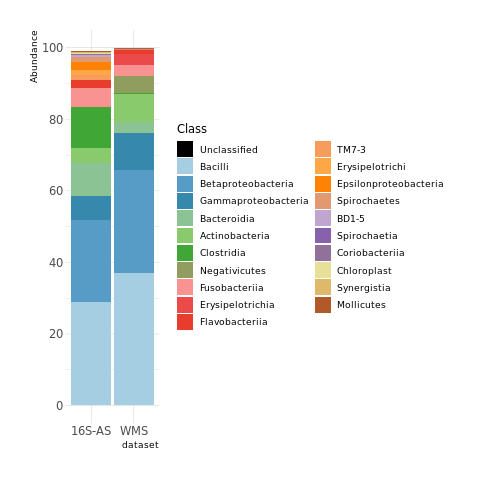

In [30]:
%%R
asv16s_bact_class_table_ps_ra_summary$dataset <- "16S-AS"
wms_bact_class_abund_ra_summary$dataset <- "WMS"
wms_bact_class_abund_ra_summary$Class <- stringr::str_replace(wms_bact_class_abund_ra_summary$Class, 
                                                              "Candidatus_Saccharibacteria", "TM7")
asv16s_and_wms_bact_class_abund_summary <- rbind(asv16s_bact_class_table_ps_ra_summary, 
                                                 wms_bact_class_abund_ra_summary)

asv16s_and_wms_bact_class_abund_plot <- plot_relative_abundance_summary(asv16s_and_wms_bact_class_abund_summary, 
                                                                        threshold=0.1, 
                                                                        by_var='dataset',rank="Class", 
                                                                        scale="percent")
asv16s_and_wms_bact_class_abund_plot

### 3.4 Bacterial Order

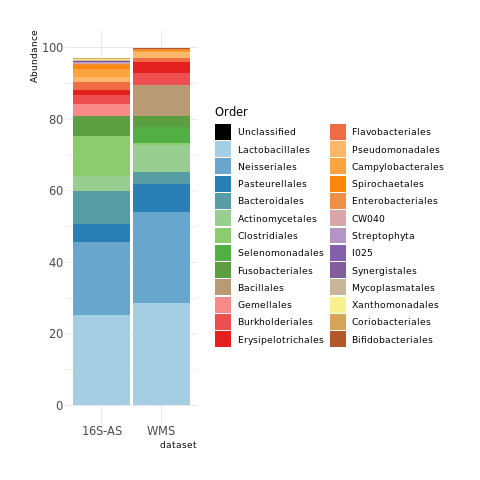

In [31]:
%%R
asv16s_bact_order_table_ps_ra_summary$dataset <- "16S-AS"
wms_bact_order_abund_ra_summary$dataset <- "WMS"
wms_bact_order_abund_ra_summary$Order <- stringr::str_replace(wms_bact_order_abund_ra_summary$Order, 
                                                              "Candidatus_Saccharibacteria", "TM7")
asv16s_and_wms_bact_order_abund_summary <- rbind(asv16s_bact_order_table_ps_ra_summary, 
                                                 wms_bact_order_abund_ra_summary)

asv16s_and_wms_bact_order_abund_plot <- plot_relative_abundance_summary(asv16s_and_wms_bact_order_abund_summary, 
                                                                        threshold=0.1, 
                                                                        by_var='dataset',rank="Order", 
                                                                        scale="percent")
asv16s_and_wms_bact_order_abund_plot

### 3.5 Bacterial Family

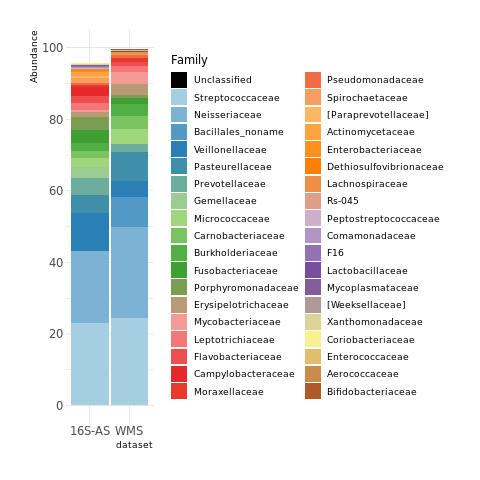

In [32]:
%%R
asv16s_bact_family_table_ps_ra_summary$dataset <- "16S-AS"
wms_bact_family_abund_ra_summary$dataset <- "WMS"
wms_bact_family_abund_ra_summary$Family <- stringr::str_replace(wms_bact_family_abund_ra_summary$Family, 
                                                              "Candidatus_Saccharibacteria", "TM7")
asv16s_and_wms_bact_family_abund_summary <- rbind(asv16s_bact_family_table_ps_ra_summary, 
                                                 wms_bact_family_abund_ra_summary)
asv16s_and_wms_bact_family_abund_plot <- plot_relative_abundance_summary(asv16s_and_wms_bact_family_abund_summary, 
                                                                        threshold=0.1, 
                                                                        by_var='dataset',rank="Family",
                                                                         scale="percent")
asv16s_and_wms_bact_family_abund_plot

### 3.6 Bacterial Genera

In [18]:
%%R -w 700
asv16s_bact_genus_table_ps_ra_summary$dataset <- "16S-AS"
wms_bact_genus_abund_ra_summary$dataset <- "WMS"
wms_bact_genus_abund_ra_summary$Genus <- stringr::str_replace(wms_bact_genus_abund_ra_summary$Genus, 
                                                              "Candidatus_Saccharibacteria", "TM7")
asv16s_and_wms_bact_genus_abund_summary <- rbind(asv16s_bact_genus_table_ps_ra_summary, 
                                                 wms_bact_genus_abund_ra_summary)
asv16s_and_wms_bact_genus_abund_plot <- plot_relative_abundance_summary(asv16s_and_wms_bact_genus_abund_summary, 
                                                                        threshold=0.1, 
                                                                        by_var='dataset',rank="Genus", scale='percent') +
                                            labs(x="",y="Abundance (%)")
asv16s_and_wms_bact_genus_abund_plot

**Mean abundances of genera not detected by WMS**

In [19]:
%%R
print(length(asv16s_bact_genus_table_ps_ra_summary$Genus))
print(length(wms_bact_genus_abund_ra_summary$Genus))

[1] 320
[1] 78


In [20]:
%%R
genera_in16S_notInWMS <- setdiff(asv16s_bact_genus_table_ps_ra_summary$Genus,
                                 wms_bact_genus_abund_ra_summary$Genus)
print(length(genera_in16S_notInWMS))

[1] 266


In [69]:
%%R
head(genera_in16S_notInWMS_ra_summary)

               Genus   N    Abundance           sd           se           lci          uci dataset grouping
1   g__[Eubacterium] 307 3.781205e-05 0.0005269035 3.003589e-05 -1.377838e-05 1.746396e-04  16S-AS        1
2    g__[Prevotella] 307 6.561589e-01 1.8831688963 1.147058e-01  4.579618e-01 1.076923e+00  16S-AS        2
3            g__1-68 307 7.882128e-06 0.0001381060 7.473026e-06  2.012595e-06 7.882128e-06  16S-AS        3
5    g__Acholeplasma 307 1.790390e-02 0.0729251065 4.173475e-03  9.566456e-03 3.466153e-02  16S-AS        4
6   g__Achromobacter 307 2.207012e-03 0.0225862607 1.313374e-03 -9.334227e-04 5.267536e-02  16S-AS        5
7 g__Acidaminococcus 307 4.829633e-04 0.0030701947 1.638500e-04  2.070185e-04 9.983499e-04  16S-AS        6


[1] 13.88889 16.66667


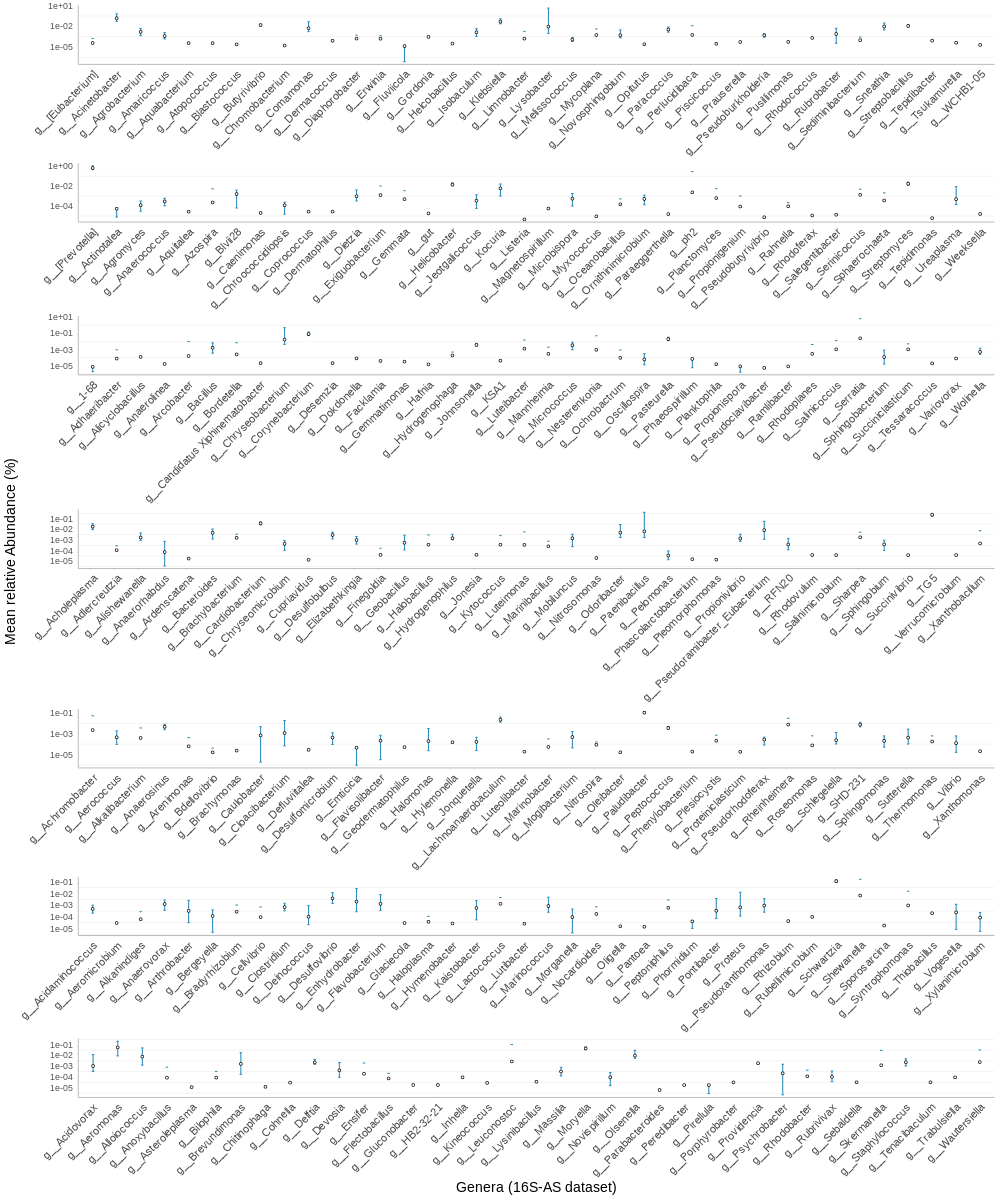

In [72]:
%%R -w 1000 -h 1200
print(par('din'))
genera_in16S_notInWMS_ra_summary <- asv16s_bact_genus_table_ps_ra_summary[asv16s_bact_genus_table_ps_ra_summary$Genus %in% genera_in16S_notInWMS,]

# Divide the 266 genera in seven groups of 38
genera_in16S_notInWMS_ra_summary$grouping <- rep(seq(1,7),38)

genera_in16S_notInWMS_ra_plot <- ggplot(subset(genera_in16S_notInWMS_ra_summary, !is.na(Genus)), 
                                            aes(x=Genus,y=Abundance)) + 
                                        geom_errorbar(aes(ymin=lci, ymax=uci), colour="#2b8cbe", width=.1) + 
                                        geom_point(size=1, shape=21, fill="white") + 
                                        #coord_cartesian(ylim=c(0,0.5)) + 
                                        scale_y_log10() +
                                        facet_wrap(~ grouping, scale="free", ncol=1) + 
                                        labs(x="Genera (16S-AS dataset)", y="Mean relative Abundance (%)") +
                                        theme_minimal() + 
                                        theme(axis.title=element_text(size=14), 
                                              axis.text.x = element_text(size=11, angle = 45, hjust = 1), 
                                              strip.text.x = element_blank(), 
                                              axis.title.y = element_text(margin = margin(r=30)), 
                                              axis.line = element_line(colour = "grey"), 
                                              panel.grid.major = element_blank(),
                                              #panel.grid.minor = element_blank()
                                             )
print(genera_in16S_notInWMS_ra_plot)

# Saving panel
genera_in16S_notInWMS_ra_plot_file <- "./reports/figures/genera_in16S_notInWMS_mean_ra.svg"
ggsave(genera_in16S_notInWMS_ra_plot_file, genera_in16S_notInWMS_ra_plot, width=13.89, height=16.667)

## 4. Plot heatmaps of individual relative abundances

**Helper functions for plotting**

In [34]:
%%R

sort_hclust <- function(...) as.hclust(dendsort(as.dendrogram(...), isReverse = TRUE))

# Overwrite default draw_colnames in the pheatmap package.
# Thanks to Josh O'Brien at http://stackoverflow.com/questions/15505607
draw_colnames_45 <- function (coln, gaps, ...) {
    coord <- pheatmap:::find_coordinates(length(coln), gaps)
    x     <- coord$coord - 0.5 * coord$size
    res   <- grid::textGrob(
      coln, x = x, y = unit(1, "npc") - unit(3,"bigpts"),
      vjust = 0.75, hjust = 1, rot = 45, gp = grid::gpar(...)
    )
    return(res)
}
assignInNamespace(
  x = "draw_colnames",
  value = "draw_colnames_45",
  ns = asNamespace("pheatmap")
)

# Define legends for annotations
create_cont_gglegend <- function(name,values,limits=c(0,1),
                                 breaks=c(-0.1,0,0.2,0.4,0.6,0.8),
                                 colors=c("black","red"),position="bottom"){
    dummy_plot <- ggplot() +
    geom_tile(aes(x='1', y=values, fill=values)) + 
    scale_fill_gradientn(name=name,
                         values=rescale(values, to=c(0,1)),
                         limits=limits,
                         breaks=breaks,
                         colors=colors
                         ) + 
    theme_void() + 
    theme(legend.title=element_text(size=11,face='bold'), 
          legend.text=element_text(size=11))
    if(position=="bottom"){
        dummy_plot <- dummy_plot +
        theme(legend.position=position) +
        guides(fill=guide_colourbar(title.position="top",barwidth=10))

    }
    cowplot::get_legend(dummy_plot)
}

# Define legends for annotations
create_gglegend <- function(name,values,colors,position){
    dummy_plot <- ggplot() +
    geom_tile(aes(x='1', y=values, fill=values)) + 
    scale_fill_manual(name=name, 
                      breaks=levels(values),
                      values=colors, 
                      labels=levels(values)) + 
    theme_void() + 
    theme(legend.title=element_text(size=11,face='bold'), 
          legend.text=element_text(size=11))
    if(position=="bottom"){
        dummy_plot <- dummy_plot +
        theme(legend.position=position) +
        guides(fill=guide_legend(title.position="top",barwidth=10))
    }
    cowplot::get_legend(dummy_plot)
}


**Create color bars for heatmaps and define annotation color for clinical variables**

In [35]:
%%R
# Define colors for pheatmap
# --------------------------
color_palette_blues <- colorRampPalette(c("#f7fcf0", "#084081"))
color_palette_reds <- colorRampPalette(brewer.pal(9, "YlOrRd"))

# To color relative abundances with zero values in white
breaks_below1 <- seq(0,1, length.out=100) # below 1% in blue scale
breaks_above1 <- seq(1.05,100, length.out=100) # above 1%, colored from orange to red
color_breaks <- c(-0.1,breaks_below1,breaks_above1)
color_colors <- c("black",rev(color_palette_blues(length(breaks_below1))), 
                  color_palette_reds(length(breaks_above1)-1))

colorbar_blv1 <- create_cont_gglegend(name="Abundance (%)",
                                      values=breaks_below1,
                                      breaks=c(-0.1,0,0.2,0.4,0.6,0.8,1),
                                      limits=c(0,1),
                                      colors=c("black",rev(color_palette_blues(length(breaks_below1))))
                                     )
colorbar_abv0 <- create_cont_gglegend(name="Abundance (%)",
                                      values=seq(1.05,100, length.out=100),
                                      breaks=c(1,20,40,60,80,100),
                                      limits=c(1,100),
                                      colors=color_palette_reds(length(breaks_above1)-1))


cxr_colors <- c("#DCDCDC", brewer.pal(3,"OrRd"))
age_colors <- brewer.pal(4,"YlGnBu")
season_colors <- brewer.pal(3,"Paired")
vars_annotation_colors <- list('CXR: Abnormal'           =c(Normal="#DCDCDC",Abnormal="black"),
                               'CXR cavities: Present'   =c(no="#DCDCDC",yes="black"),
                               'CXR infiltrates: Present'=c(no="#DCDCDC",yes="black"),
                               'CXR findings'  =c(Normal =cxr_colors[1], 
                                                  "Abnormal(other)"=cxr_colors[2], 
                                                  "Infiltrate_Cavitary"=cxr_colors[3],
                                                  "Infiltrate_Non-cavitary"=cxr_colors[4]),
                               'Clinical findings: Severe'   =c(Mild="#DCDCDC",Severe="black"),
                               'Mycobacterial load: High' =c(Low="#DCDCDC",High="black"),
                               'Sex: Male'       =c(Female="#DCDCDC",Male="black"),
                               'Age ranges'      =c("<25"=age_colors[1],"25-34"=age_colors[2],
                                                    "35-44"=age_colors[3],">44"=age_colors[4]),
                               'BMI: < 18.5'      =c("Normal/Obese BMI>=18.5"='#DCDCDC',
                                                    "Underweight BMI<18.5"="black"),
                               'Hemoglobin <10'  =c(">=10"="#DCDCDC","<10"="black"),
                               'Anemia: Yes'     =c(No="#DCDCDC",Yes="black"),
                               'HIV: Positive'   =c(negative='#DCDCDC', positive='black'),
                               'URI (virus)'     =c(no='#DCDCDC',yes='black'), 
                               'URI (bacteria)'  =c(no='#DCDCDC',yes='black'),
                               'Helminths'       =c(negative='#DCDCDC', positive='black'),
                               'Smoker: Yes'          =c(no='#DCDCDC',yes='black'),
                               'Alcohol abuse: Yes'   =c(no='#DCDCDC',yes='black'),
                               'Season'               =c("Short Rains (Oct. - Feb.)"=season_colors[1],
                                                         "Long Rains (March - May)"=season_colors[2],
                                                         "Dry (June - Sept.)"=season_colors[3])
                              )


### 4.1 Heatmap of WMS-based taxonomic profiles

**Retrieve clinical metadata**

In [36]:
%%R
# Sample clinical metadata
# ------------------------
sample_metadata_vars <- c("xray_findings","smear_grading_bin","tbscore_bin","bmi_cat","anemia_bin",
                          "hiv","cd4count_cat","viral","bacterial","helminth","smoking","alcoholabuse","male")
wms_sample_metadata <- wms_mapping_ids[colnames(wms_kigdom_abund_table),]
wms_sample_metadata <- cbind(wms_sample_metadata, 
                             sample_metadata[wms_sample_metadata$SubjectID,sample_metadata_vars])
head(wms_sample_metadata)

       SpecimenID SubjectID xray_findings smear_grading_bin tbscore_bin                bmi_cat anemia_bin      hiv cd4count_cat viral bacterial helminth smoking alcoholabuse   male
M00186     S00251    H00248          <NA>              High        Mild Normal/Obese BMI>=18.5        Yes positive         <200    no      <NA> positive      no           no Female
M00158     S00340    H00333        Normal              High      Severe   Underweight BMI<18.5        Yes positive         <200   yes        no negative      no           no   Male
M00046     S00165    H00165          <NA>               Low      Severe   Underweight BMI<18.5        Yes negative         <NA>    no       yes positive      no           no   Male
M00125     S00182    H00184        Normal              High        Mild Normal/Obese BMI>=18.5        Yes negative         <NA>    no       yes positive      no          yes   Male
M00208     S00298    H00294          <NA>              High      Severe   Underweight BMI<18.5 

**Heatmap of Domains and viruses relative abundances**

[1] 6.944444 6.944444


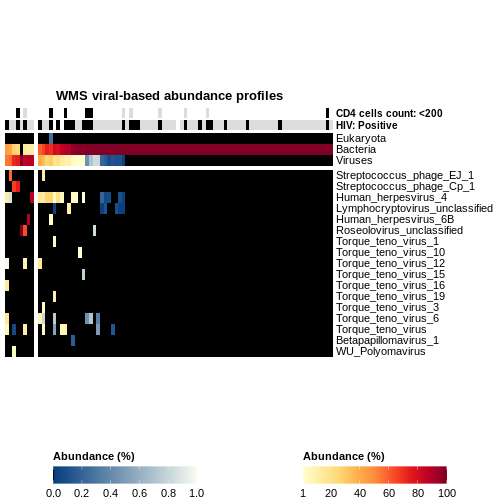

In [37]:
%%R -w 500 -h 500 -u px
print(par('din'))

# Define data to plot
# -------------------
# Relative abundances at the Domain level (from WMS data)
wms_kigdom_abund_table_toplot <- wms_kigdom_abund_table
rownames(wms_kigdom_abund_table_toplot) <- stringr::str_replace(rownames(wms_kigdom_abund_table),"k__","")

# Relative abundance of viruses (from WMS data)
wms_virus_spp <- grep("^k__Viruses[[:graph:]]*\\|s__[^\\|]*$", rownames(wms_abundance_table), value=TRUE)
wms_virus_spp_ra <- wms_abundance_table[wms_virus_spp,]
wms_virus_spp_ra <- wms_virus_spp_ra[rowSums(wms_virus_spp_ra) > 0,]
wms_virus_full_taxonomy <- rownames(wms_virus_spp_ra)

#-rename rows, keep only species name
wms_strain_names <- unlist(lapply(rownames(wms_virus_spp_ra), 
                                  function(x){tail(strsplit(x, split="\\|s__")[[1]], n=1)}))
rownames(wms_virus_spp_ra) <- wms_strain_names


# Annotations for pheatmap
# ------------------------
wms_virus_spp_sample_annotation <- data.frame("HIV: Positive" = wms_sample_metadata$hiv,
                                              "CD4 cells count: <200" = wms_sample_metadata$cd4count_cat, 
                                              check.names = FALSE)
rownames(wms_virus_spp_sample_annotation) <- rownames(wms_sample_metadata)
wms_virus_spp_annotation_colors <- list("HIV: Positive"         =c(negative="#DCDCDC", positive="black"),
                                        "CD4 cells count: <200" =c(">=200"="#DCDCDC", "<200"="black"))

# Plot
# ------
# to sort dendrogram
wms_kigdom_abund_cluster_samples <- sort_hclust(hclust(vegdist(t(wms_kigdom_abund_table_toplot), 
                                                               method='bray')))

wms_virus_abund_hmap <- pheatmap(rbind(wms_kigdom_abund_table_toplot[c("Eukaryota","Bacteria","Viruses"),],
                                       wms_virus_spp_ra), 
                                 color=color_colors, 
                                 breaks=color_breaks, 
                                 border_color=NA, 
                                 show_rownames = TRUE,
                                 show_colnames= FALSE,
                                 cellheight=11, 
                                 fontsize_row=11,
                                 cluster_cols=wms_kigdom_abund_cluster_samples, 
                                 treeheight_col=0,
                                 cluster_rows=F, 
                                 cutree_cols=2,
                                 gaps_row=c(3),
                                 annotation_col=wms_virus_spp_sample_annotation, 
                                 annotation_colors=wms_virus_spp_annotation_colors, 
                                 annotation_legend=FALSE,
                                 legend=FALSE, 
                                 main="WMS viral-based abundance profiles", 
                                 just="right", silent=TRUE)

grid.arrange(grobs=list(wms_virus_abund_hmap[[4]],
                        cbind(colorbar_blv1, colorbar_abv0, size="last")),
             #layout_matrix=heatmap_layout, 
             heights=c(0.9,0.1))

Lets test the potential association of viral DNA detection and HIV positivity:

In [38]:
%%R
# Test association of viral detection and HIV positivity
has_viruses <- t(wms_kigdom_abund_table_toplot["Viruses",]>0)
has_hiv <- wms_sample_metadata[rownames(has_viruses),'hiv']

print(table(has_viruses,has_hiv))
print(prop.table(table(has_viruses,has_hiv),margin=2))
print(prop.table(table(has_viruses,has_hiv),margin=1))
print(chisq.test(has_viruses,has_hiv))

           has_hiv
has_viruses negative positive
      FALSE       44       12
      TRUE        17       13
           has_hiv
has_viruses  negative  positive
      FALSE 0.7213115 0.4800000
      TRUE  0.2786885 0.5200000
           has_hiv
has_viruses  negative  positive
      FALSE 0.7857143 0.2142857
      TRUE  0.5666667 0.4333333

	Pearson's Chi-squared test with Yates' continuity correction

data:  has_viruses and has_hiv
X-squared = 3.5456, df = 1, p-value = 0.0597



**Heatmap of species-level relative abundances**

[1] 13.88889 11.11111

Prevalence cut-off: 3
Nr. species removed (prevalence < 3):  66
Samples(IDs) with zero totals removed: M00224
Dimensions(species-by-samples) of filtered table:  103 88 
       s__Actinomyces_graevenitzii s__Actinomyces_odontolyticus
M00186                  -0.4351538                   -0.4351538
M00158                  -1.9897717                   -1.9897717
M00046                   9.3393974                   -2.1389012
M00125                  -2.0397960                   -2.0397960
M00208                  -4.6453694                   -4.6453694


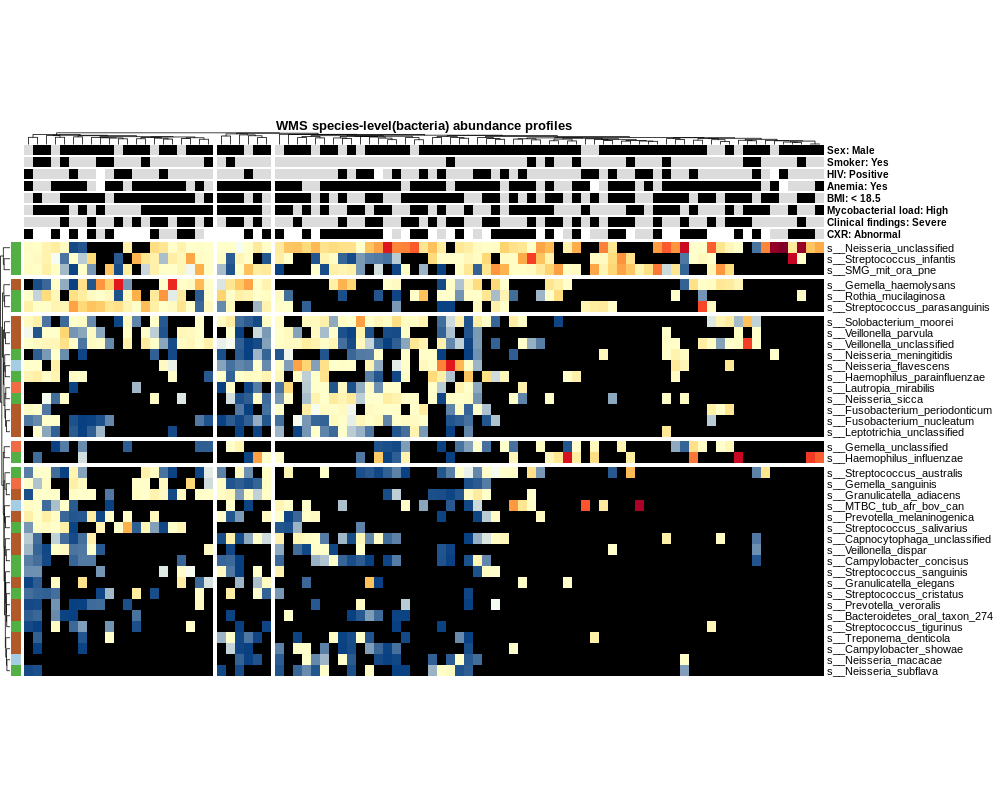

In [39]:
%%R -h 800 -w 1000 -u px
print(par('din'))
# Compute Aitchison distances for subsequent sorting #
# ---------------------------------------------------#
# CLR-transformation of counts
# ----------------------------
wms_bacteria_spp_counts_clr <-  wms_bacteria_spp_counts_table

# Filter rare species
# Keep those present in at least three samples
spp_prevalence_cutoff <- 3
cat("\nPrevalence cut-off: ")
cat(spp_prevalence_cutoff)
spp_is_abv_cutoff <- as.vector(rowSums(wms_bacteria_spp_counts_clr>0) >= spp_prevalence_cutoff)
wms_bacteria_spp_counts_clr <- wms_bacteria_spp_counts_clr[spp_is_abv_cutoff,]
cat("\nNr. species removed (prevalence < 3): ", sum(!spp_is_abv_cutoff))

# Remove samples with zero totals
wms_sample_has_zero_totals <- as.vector(colSums(wms_bacteria_spp_counts_clr)==0)
if(sum(wms_sample_has_zero_totals)>0){
    cat("\nSamples(IDs) with zero totals removed: ")
    cat(colnames(wms_bacteria_spp_counts_clr)[wms_sample_has_zero_totals])
    wms_bacteria_spp_counts_clr <- wms_bacteria_spp_counts_clr[,!wms_sample_has_zero_totals]
}
cat("\nDimensions(species-by-samples) of filtered table: ",
    dim(wms_bacteria_spp_counts_clr),'\n')

# Then, replace zeroes, returns a sample-by-features table (samples as rows)
wms_bacteria_spp_counts_clr <- cmultRepl(t(wms_bacteria_spp_counts_clr), 
                                         label=0, method="CZM", output="p-counts")
# Finally, apply CLR-transformation
wms_bacteria_spp_counts_clr <- t(apply(wms_bacteria_spp_counts_clr, 1, function(x){log(x) - mean(log(x))}))
print(wms_bacteria_spp_counts_clr[1:5,1:2])

# Compute Aitchison distances
# ---------------------------
wms_bacteria_spp_samples_pairwise_dist <- dist(wms_bacteria_spp_counts_clr)
wms_bacteria_spp_species_pairwise_dist <- dist(t(scale(wms_bacteria_spp_counts_clr, 
                                                       center=FALSE, scale=FALSE)))

# Define data to plot                               #
# --------------------------------------------------#
# Species-level relative abundances
wms_bactSpp_ra_toplot <- wms_bacteria_spp_abund_table
wms_bactSpp_ra_toplot <- wms_bactSpp_ra_toplot[colnames(wms_bacteria_spp_counts_clr),
                                               rownames(wms_bacteria_spp_counts_clr)]

# Ordering of samples based on Aitchison distance
wms_bactSpp_cluster_samples <- sort_hclust(hclust(wms_bacteria_spp_samples_pairwise_dist))

# Ordering of species based on Aitchison distances
# Display only spp present in at least 15% of the samples
wms_bactSpp_spp_prev <- data.frame("n_samples"=rowSums(wms_bactSpp_ra_toplot>0))
spp_presence_threshold <- round(0.15*(dim(wms_bactSpp_ra_toplot)[2]))
spp_to_display <- rownames(wms_bactSpp_spp_prev)[which(wms_bactSpp_spp_prev$n_samples>=spp_presence_threshold)]
wms_bactSpp_cluster_spp <- sort_hclust(hclust(dist_subset(wms_bacteria_spp_species_pairwise_dist, 
                                                            spp_to_display)))

# rename some species
wms_bactSpp_data_for_heatmap <- wms_bactSpp_ra_toplot[spp_to_display,]

spp_ranaming <- list("s__Mycobacterium_tuberculosis_bovis_africanum_canetti"="s__MTBC_tub_afr_bov_can",
                     "s__Streptococcus_mitis_oralis_pneumoniae"="s__SMG_mit_ora_pne")
rownames(wms_bactSpp_data_for_heatmap) <- plyr::mapvalues(rownames(wms_bactSpp_data_for_heatmap), 
                                                          from=names(spp_ranaming), 
                                                          to=unlist(unname(spp_ranaming)))

# Annotations for heatmap                           #
#---------------------------------------------------#
# Annotations for samples
#------------------------
wms_bactSpp_sample_annotation <- data.frame('CXR: Abnormal'            =wms_sample_metadata$xray_findings,
                                            'Clinical findings: Severe'         =wms_sample_metadata$tbscore_bin,
                                            'Mycobacterial load: High' =wms_sample_metadata$smear_grading_bin,
                                            'BMI: < 18.5'    =wms_sample_metadata$bmi_cat,
                                            'Anemia: Yes'        =wms_sample_metadata$anemia_bin,
                                            'HIV: Positive'           =wms_sample_metadata$hiv,
                                            'Smoker: Yes'        =wms_sample_metadata$smoking,
                                            'Sex: Male'     =wms_sample_metadata$male,
                                            check.names = FALSE)
rownames(wms_bactSpp_sample_annotation) <- rownames(wms_sample_metadata)


# Annotations for species
#------------------------
# Mode of metabolism
wms_spp_metabolism <- wms_spp_metabolism_req[gsub("^s__","",rownames(wms_bactSpp_ra_toplot[spp_to_display,])),
                       "oxygen_requirement"]
wms_spp_metabolism <- factor(wms_spp_metabolism, 
                             levels=c("aerobe","microaerophile","Facultative anaerobe",
                                      "aerobe; capnophilic; facultative anaerobe","anaerobe"), 
                             labels=c("Aerobe","Microaerophile","Facultative Anaerobe", 
                                      "Ae/C/FA","Anaerobe"))

wms_bactSpp_spp_annotation <- data.frame("Mode of metabolism" = wms_spp_metabolism, check.names = FALSE)
rownames(wms_bactSpp_spp_annotation) <- rownames(wms_bactSpp_data_for_heatmap)

# Annotation colors
wms_spp_colors <- colorRampPalette(brewer.pal(12, "Paired"))(length(levels(wms_spp_metabolism)))
names(wms_spp_colors)<- levels(wms_spp_metabolism)

wms_bactSpp_annotation_colors <- c(vars_annotation_colors,
                                   'Mode of metabolism'=list(wms_spp_colors))

wms_spp_colors_legend <- create_gglegend(name='Mode of metabolism', 
                                         values=wms_spp_metabolism, 
                                         colors=wms_spp_colors, 
                                         position="bottom")

# Plot heatmap                                      #
#---------------------------------------------------#
wms_bactSpp_heatmap <- pheatmap(wms_bactSpp_data_for_heatmap,   
         color=color_colors,
         breaks=color_breaks,
         scale='none',
         border_color=NA, 
         show_rownames = TRUE,
         #labels_row = genus_to_display_labels,
         show_colnames= FALSE,
         cellheight=11, 
         fontsize_row=11,
         cluster_cols=wms_bactSpp_cluster_samples, 
         cluster_rows=wms_bactSpp_cluster_spp, 
         cutree_cols=3,
         cutree_rows=5,
         treeheight_col=7,
         treeheight_row=5,
         annotation_col=wms_bactSpp_sample_annotation, 
         annotation_row=wms_bactSpp_spp_annotation,
         annotation_colors=wms_bactSpp_annotation_colors,
         annotation_names_row=FALSE,
         #angle_col=315,
         annotation_legend=FALSE, 
         legend=FALSE,
         main="WMS species-level(bacteria) abundance profiles", 
         silent=FALSE)

#grid.arrange(grobs=list(wms_bactSpp_heatmap[[4]], wms_spp_colors_legend), nrow=2)

### 4.2 Heatmap of 16S-AS taxonomic profiles

**Retrieve clinical metadata**

In [40]:
%%R
# Sample clinical metadata
# ------------------------
sample_metadata_vars <- c("xray_findings","smear_grading_bin","tbscore_bin","bmi_cat","anemia_bin",
                          "hiv","cd4count_cat","viral","bacterial","helminth","smoking","alcoholabuse","male")

asv16s_sample_metadata <- asv16s_mapping_ids[sample_names(asv16s_feature_table_ps),]
asv16s_sample_metadata <- cbind(asv16s_sample_metadata, 
                                sample_metadata[asv16s_sample_metadata$SubjectID, sample_metadata_vars])
head(asv16s_sample_metadata)

       SpecimenID SubjectID seq_run xray_findings smear_grading_bin tbscore_bin                bmi_cat anemia_bin      hiv cd4count_cat viral bacterial helminth smoking alcoholabuse   male
A00030     S00394    H00388    run1          <NA>              High        Mild   Underweight BMI<18.5       <NA> positive        >=200    no       yes negative      no           no Female
A00034     S00426    H00421    run1          <NA>               Low        Mild Normal/Obese BMI>=18.5        Yes positive        >=200   yes       yes positive      no           no Female
A00036     S00173    H00173    run1          <NA>               Low        Mild   Underweight BMI<18.5        Yes negative         <NA>    no        no negative      no           no   Male
A00038     S00269    H00266    run1          <NA>              High      Severe   Underweight BMI<18.5        Yes negative         <NA>   yes        no negative      no          yes   Male
A00056     S00050    H00049    run1      Abnormal      

**Heatmap of genus-level relative abundances**

In [41]:
%%R
# Extract counts
asv16s_bacteria_genus_counts_ps <- tax_glom(subset_taxa(asv16s_feature_table_ps, Kingdom=="k__Bacteria"), 
                                            "Genus", NArm=FALSE)

[1] 13.88889 11.11111

Prevalence cut-off: 15
Dimensions(genera-by-samples) of filtered table:  147 307 
No. corrected values:  1575 
       00054bda86b78c430a861fa6dbd577f9 00ffa6dec3ed0e17e1ffe754cdb8c629
A00030                        0.9746196                        0.9746196
A00034                       -0.6501133                       -0.6501133
A00036                       -1.1481609                       -1.1481609
A00038                       -1.7419236                       -1.2766701
A00056                       -2.2738214                       -1.7088573


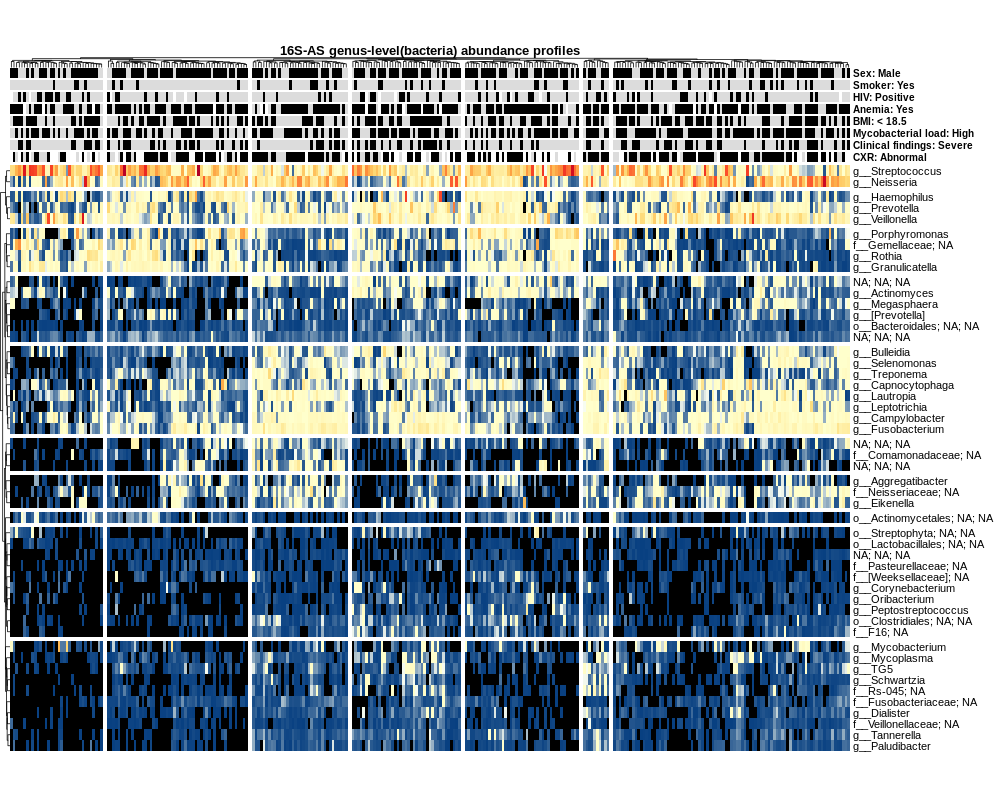

In [42]:
%%R -h 800 -w 1000 -u px
print(par('din'))

# Compute Aitchison distances for subsequent sorting #
# ---------------------------------------------------#
# CLR-transformation of counts
# ----------------------------
asv16s_bacteria_genus_counts_clr <-  otu_table(asv16s_bacteria_genus_counts_ps)

# Filter rare genus
# Keep those which are at least 5% prevalent in the dataset
prevalence_cutoff <- round(5*(dim(asv16s_bacteria_genus_counts_clr)[2])/100)
cat("\nPrevalence cut-off: ")
cat(prevalence_cutoff)
genus_is_abv_cutoff <- as.vector(rowSums(asv16s_bacteria_genus_counts_clr>0) >= prevalence_cutoff)
asv16s_bacteria_genus_counts_clr <- asv16s_bacteria_genus_counts_clr[genus_is_abv_cutoff,]

# Remove samples with zero totals
sample_has_zero_totals <- as.vector(colSums(asv16s_bacteria_genus_counts_clr)==0)
if(sum(sample_has_zero_totals)>0){
    cat("\nSamples with zero totals removed: ")
    cat(colnames(asv16s_bacteria_genus_counts_clr)[sample_has_zero_totals])
    asv16s_bacteria_genus_counts_clr <- asv16s_bacteria_genus_counts_clr[,!sample_has_zero_totals]
}
cat("\nDimensions(genera-by-samples) of filtered table: ",
    dim(asv16s_bacteria_genus_counts_clr),'\n')

# Then, replace zeroes, returns a sample-by-features table (samples as rows)
asv16s_bacteria_genus_counts_clr <- cmultRepl(t(asv16s_bacteria_genus_counts_clr), 
                                              label=0, method="CZM", output="p-counts")
# Finally, apply CLR-transformation
asv16s_bacteria_genus_counts_clr <- t(apply(asv16s_bacteria_genus_counts_clr, 1, 
                                            function(x){log(x) - mean(log(x))}))
print(asv16s_bacteria_genus_counts_clr[1:5,1:2])

# Aitchison distances on CLR-transformed data
# --------------------------------------------
asv16s_bactGenera_samples_pairwise_dist <- dist(asv16s_bacteria_genus_counts_clr)
asv16s_bactGenera_genus_pairwise_dist <- dist(t(scale(asv16s_bacteria_genus_counts_clr,
                                                      center=FALSE,scale=FALSE)))

# Define data to plot (relative abundances)           #
# ----------------------------------------------------#
asv16s_bacteria_genus_ra <- otu_table(transform_sample_counts(asv16s_bacteria_genus_counts_ps,
                                                                     function(x){(x/sum(x))*100}))
asv16s_bacteria_genus_ra <- asv16s_bacteria_genus_ra[colnames(asv16s_bacteria_genus_counts_clr),
                                                     rownames(asv16s_bacteria_genus_counts_clr)]

# Cluster and reorder samples based on Aitchison distances
asv16s_bacteria_genus_cluster_samples <- sort_hclust(hclust(asv16s_bactGenera_samples_pairwise_dist))

# Cluster and reorder genus based on Aitchison distances
# Display only genera present in at least 50% of the samples
asv16s_bacteria_genus_prev <- data.frame("n_samples"=rowSums(otu_table(asv16s_bacteria_genus_counts_ps)>0))
genus_presence_threshold <- round(0.5*(dim(asv16s_bacteria_genus_counts_clr)[1]))
genus_to_display <- rownames(asv16s_bacteria_genus_prev)[which(asv16s_bacteria_genus_prev$n_samples>=genus_presence_threshold)]
asv16s_bactGenera_cluster_genus <- sort_hclust(hclust(dist_subset(asv16s_bactGenera_genus_pairwise_dist, 
                                                                  genus_to_display)))

# Annotations for heatmap                           #
#---------------------------------------------------#
# Annotations for samples
#------------------------
asv16s_bactGenera_sample_annotation <- data.frame('CXR: Abnormal'            =asv16s_sample_metadata$xray_findings,
                                                  'Clinical findings: Severe'         =asv16s_sample_metadata$tbscore_bin,
                                                  'Mycobacterial load: High' =asv16s_sample_metadata$smear_grading_bin,
                                                  #'Age ranges'    =asv16s_sample_metadata$age_cat,
                                                  'BMI: < 18.5'    =asv16s_sample_metadata$bmi_cat,
                                                  'Anemia: Yes'        =asv16s_sample_metadata$anemia_bin,
                                                  'HIV: Positive'           =asv16s_sample_metadata$hiv,
                                                  'Smoker: Yes'        =asv16s_sample_metadata$smoking,
                                                  'Sex: Male'     =asv16s_sample_metadata$male,
                                                  check.names = FALSE
                                                 )
rownames(asv16s_bactGenera_sample_annotation) <- rownames(asv16s_sample_metadata)

# Annotations for Genera
#------------------------
genus_to_display_labels <- unlist(lapply(genus_to_display, 
                                         function(x){
                                             genus_name <- tax_table(asv16s_bacteria_genus_counts_ps)[x,"Genus"]; 
                                             family_name <- tax_table(asv16s_bacteria_genus_counts_ps)[x,"Family"]; 
                                             order_name <- tax_table(asv16s_bacteria_genus_counts_ps)[x,"Order"];
                                             if(is.na(genus_name) && is.na(family_name)){
                                                 paste(order_name,"NA; NA", sep='; ')
                                             }else if(is.na(genus_name)){
                                                 paste(family_name,"NA", sep='; ')
                                             }else{
                                                 genus_name
                                             }}))

genus_to_display_phylum <- tax_table(asv16s_bacteria_genus_counts_ps)[genus_to_display,"Phylum"]
genus_to_display_phylum[,'Phylum'][is.na(genus_to_display_phylum[,'Phylum'])]<-"Unclassified"

# Plot heatmap                                      #
#---------------------------------------------------#
asv16s_bactGenera_heatmap <- pheatmap(asv16s_bacteria_genus_ra[genus_to_display,], 
                                      #color=colorRampPalette(c("#e0f3f8","black","yellow","#d73027"))(400),
                                      color=color_colors,
                                      breaks=color_breaks,
                                      scale='none', 
                                      border_color=NA, 
                                      show_rownames = TRUE, 
                                      labels_row = genus_to_display_labels,
                                      show_colnames= FALSE,
                                      cellheight=11, 
                                      fontsize_row=11,
                                      cluster_cols=asv16s_bacteria_genus_cluster_samples, 
                                      cluster_rows=asv16s_bactGenera_cluster_genus, 
                                      cutree_cols=7,
                                      cutree_rows=10,
                                      treeheight_col=5,
                                      treeheight_row=5,
                                      annotation_col=asv16s_bactGenera_sample_annotation, 
                                      #annotation_row=data.frame(genus_to_display_phylum),
                                      annotation_colors=vars_annotation_colors, 
                                      annotation_legend=FALSE, main="16S-AS genus-level(bacteria) abundance profiles", 
                                      legend=FALSE,
                                      silent=FALSE)

## 5. Overview of the sputum microbial composition in TB patients

[1] 14.58333 16.66667


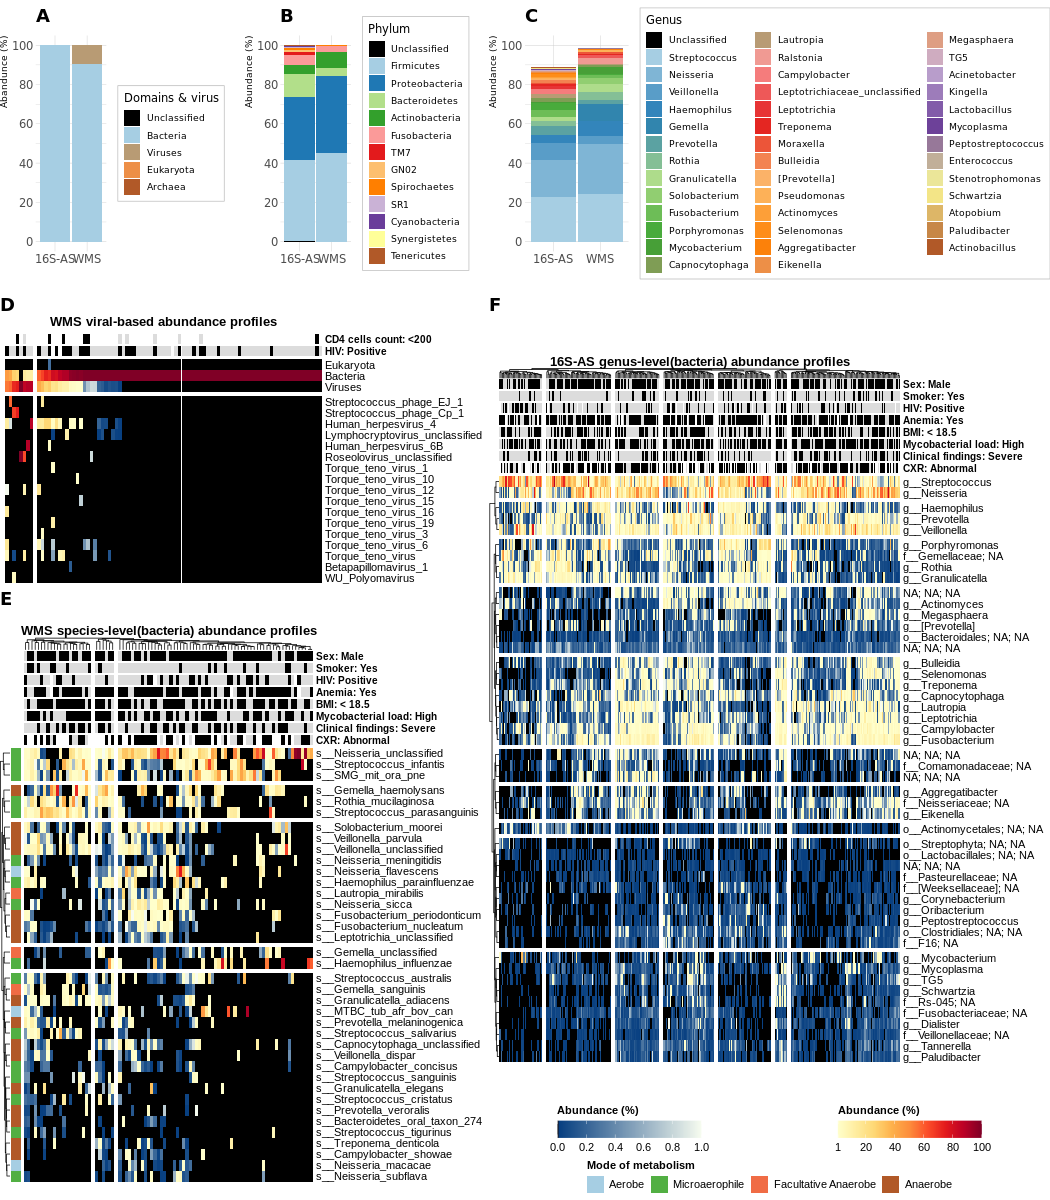

In [43]:
%%R -w 1050 -h 1200
print(par("din"))
#extrafont::font_import()
taxa_summaries_panel_layout <- rbind(c(1,NA,2,NA,3),
                                     c(4,4,4,4,8),
                                     c(5,5,5,5,9),
                                     c(6,6,6,6,9),
                                     c(7,7,7,7,9),
                                     c(7,7,7,7,10),
                                     c(7,7,7,7,11))

wms_16as_taxonomic_summaries <- grid.arrange(grobs=list(asv16s_and_wms_kingdom_abund_plot + 
                                                        theme(legend.position="right",
                                                              legend.box.background = element_rect(colour = "gray"), 
                                                              plot.margin = unit(c(0.3, 0, 0.5, 0), "cm")) + 
                                                        labs(title = "A")+
                                                        guides(fill=guide_legend(title="Domains & virus",title.position="top",ncol=1)),
                                                        # phylum-level summary
                                                        asv16s_and_wms_bact_phyla_abund_plot +  
                                                        theme(legend.position="right",legend.justification=c(0,0),
                                                              legend.box.background = element_rect(colour = "gray"),
                                                              plot.margin = unit(c(0.3, 0, 0.5, 0), "cm")) + 
                                                        labs(title = "B") + 
                                                        guides(fill=guide_legend(title.position="top", ncol=1)),
                                                        # Genus-level summay
                                                        asv16s_and_wms_bact_genus_abund_plot + 
                                                        theme(legend.position="right", 
                                                              legend.box.background = element_rect(colour = "gray"), 
                                                              plot.margin = unit(c(0.3, 0, 0.5, 0), "cm")) + 
                                                        labs(title = "C") + 
                                                        guides(fill=guide_legend(title.position="top",ncol=3)),
                                                        # Virus-level abundances
                                                        textGrob("D",just="left", x=unit(0, "npc"), 
                                                                 gp=gpar(fontfamily="Roboto Condensed",fontsize=18, fontface="bold")),
                                                        wms_virus_abund_hmap[[4]],
                                                        # Species-level abunances
                                                        textGrob("E",just="left", x=unit(0, "npc"), 
                                                                 gp=gpar(fontfamily="Roboto Condensed",fontsize=18, fontface="bold")),
                                                        wms_bactSpp_heatmap[[4]],
                                                        # Genus-level abundances
                                                        textGrob("F",just="left", x=unit(0, "npc"), 
                                                                 gp=gpar(fontfamily="Roboto Condensed",fontsize=18, fontface="bold")),
                                                        # Legends
                                                        asv16s_bactGenera_heatmap[[4]], 
                                                        cbind(colorbar_blv1, colorbar_abv0, size="last"), 
                                                        wms_spp_colors_legend),
                                             layout_matrix=taxa_summaries_panel_layout,
                                             nrow=7,ncol=5, widths=c(0.22,0.02,0.22,0.02,0.55),
                                             heights=c(0.248,0.02,0.23,0.02,0.42,0.04,0.04))

# Saving panel
wms_16as_taxonomic_summaries_file <- "./reports/figures/taxonomic_abundances_panel.svg"
ggsave(wms_16as_taxonomic_summaries_file, wms_16as_taxonomic_summaries, width=14.6, height=16.667)
